In [87]:
# !pip install "smolagents[litellm]"

In [88]:
# ! pip install duckduckgo-search

In [1]:
import json
import os
import pandas as pd 
import numpy as np
with open('../../config.json') as f:
    config = json.loads(f.read())

# os.environ["OPENAI_MODEL_NAME"]='gpt-4o-mini'  
os.environ["OPENAI_API_KEY"] = config['OPENAI_API_KEY']

In [2]:
import smolagents
smolagents.__path__

['/Users/marie/Documents/github/llm_env/lib/python3.11/site-packages/smolagents']

In [3]:
# !cat /Users/marie/Documents/github/llm_env/lib/python3.11/site-packages/smolagents/agents.py

In [4]:
from smolagents import CodeAgent, LiteLLMModel

In [5]:
model = LiteLLMModel(model_id="openai/gpt-4o-mini", api_key=config['OPENAI_API_KEY']) 
agent = CodeAgent(tools=[], model=model, add_base_tools=True)

agent.run(
    "I have 5 different balls and I randomly select 2. How many possible combinations of the balls I can get?",
)

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ I have 5 different balls and I randomly select 2. How many possible combinations of the balls I can get?        │
│                                                                                                                 │
╰─ LiteLLMModel - openai/gpt-4o-mini ─────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import math                                                                                                      
                                                                                                                   
  n = 5  # total number of balls                                                                                   
  r = 2  # number of balls to select                                                                               
  combinations = math.factorial(n) / (math.factorial(r) * math.factorial(n - r))                                   
  print(f"The number of combinations of selecting 2 balls from 5 is: {combinations}")                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
The number of combinations of selecting 2 balls from 5 is: 10.0

Out: None

[Step 1: Duration 4.94 seconds| Input tokens: 2,057 | Output tokens: 177]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer(10)                                                                                                 
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: 10

[Step 2: Duration 1.45 seconds| Input tokens: 4,437 | Output tokens: 236]

10

In [5]:
agent.memory.steps[0]

TaskStep(task='I have 5 different balls and I randomly select 2. How many possible combinations of the balls I can get?', task_images=None)

In [6]:
len(agent.memory.steps)

3

In [7]:
# agent.memory.steps[1].model_input_messages[0]

In [8]:
# agent.memory.steps[1]

### Security

In [8]:
from smolagents.local_python_executor import LocalPythonExecutor

In [10]:
custom_executor = LocalPythonExecutor(["numpy.*", "random"])

In [11]:
def run_capture_exception(command: str):
    try:
        custom_executor(harmful_command)
    except Exception as e:
        print("ERROR:\n", e)

In [13]:
harmful_command="!echo rm -rf"
run_capture_exception(harmful_command)

ERROR:
 Code parsing failed on line 1 due to: SyntaxError
!echo rm -rf
 ^
Error: invalid syntax (<unknown>, line 1)


In [15]:
harmful_command="import os; exit_code = os.system('rm -rf')"
run_capture_exception(harmful_command)

ERROR:
 Code execution failed at line 'import os' due to: InterpreterError: Import of os is not allowed. Authorized imports are: ['stat', 'statistics', 're', 'time', 'collections', 'numpy.*', 'itertools', 'datetime', 'math', 'queue', 'unicodedata', 'random']


In [16]:
harmful_command="from random import _os; exit_code = _os.system('rm -rf')"
run_capture_exception(harmful_command)

ERROR:
 Code execution failed at line 'exit_code = _os.system('rm -rf')' due to: InterpreterError: Forbidden access to module: os


In [17]:
harmful_command = '''
while True: 
    pass
'''

run_capture_exception(harmful_command)

ERROR:
 Code execution failed at line 'while True: 
    pass' due to: InterpreterError: Maximum number of 1000000 iterations in While loop exceeded


### Explaining revenue: code vs traditional tool-calling agent

In [13]:
raw_df = pd.read_csv('absolute_metrics_example.csv', sep = '\t')
df = raw_df.groupby('country')[['revenue_before', 'revenue_after_scenario_2']].sum()\
        .sort_values('revenue_before', ascending = False).rename(
            columns = {'revenue_after_scenario_2': 'after', 'revenue_before': 'before'}
        )

In [14]:
df

,before,after
country,,
other,632767.39,637000.48
UK,481409.27,477033.02
France,240704.63,107857.06
Germany,160469.75,159778.76
Italy,120352.31,121331.46
Spain,96281.86,96064.77


In [6]:
from smolagents import tool

In [7]:
@tool 
def calculate_metric_increase(before: float, after: float) -> float: 
    """
    Calculate the percentage change of the metric between before and after

    Args:
        before: value before
        after: value after
    """
    return (before - after) * 100/ before

@tool 
def calculate_sum(values: list) -> float: 
    """
    Calculate the sum of list

    Args:
        values: list of values
    """
    return sum(values)

In [8]:
agent.tools

{'web_search': <smolagents.default_tools.DuckDuckGoSearchTool at 0x11f0b7d10>,
 'visit_webpage': <smolagents.default_tools.VisitWebpageTool at 0x14115a050>,
 'final_answer': <smolagents.default_tools.FinalAnswerTool at 0x121d579d0>}

In [9]:
# traditional_agent.tools

In [10]:
agent = CodeAgent(
    model=model,
    tools=[calculate_metric_increase],
    max_steps=10,
    additional_authorized_imports=["pandas", "numpy"],
    verbosity_level=1 # lower verbosity level
)
agent.logger.console.width=66

In [29]:
len(agent.memory.steps)

0

In [30]:
task = """
Here is a pandas dataframe showing revenue by segment, comparing values before and after.
Could you please help me understand the changes?
Specifically:
1. Estimate how the total revenue and the revenue for each segment have changed, both in absolute terms and as a percentage.
2. Calculate the contribution of each segment to the total change in revenue.

Please round all floating-point numbers in the output to two decimal places.
"""
agent.logger.level = 1 # Lower verbosity level
agent.run(
    task,
    additional_args={"df": df},
)

╭─────────────────────────── New run ────────────────────────────╮
│                                                                │
│ Here is a pandas dataframe showing revenue by segment,         │
│ comparing values before and after.                             │
│ Could you please help me understand the changes?               │
│ Specifically:                                                  │
│ 1. Estimate how the total revenue and the revenue for each     │
│ segment have changed, both in absolute terms and as a          │
│ percentage.                                                    │
│ 2. Calculate the contribution of each segment to the total     │
│ change in revenue.                                             │
│                                                                │
│ Please round all floating-point numbers in the output to two   │
│ decimal places.                                                │
│                                                                │
│ You have been provided with these additional arguments         │
│ available as variables with names df. You can access them      │
│ directly. Here is what they contain (just for informational    │
│ purposes): {'df':             before      after                │
│ country                                                        │
│ other    632767.39  637000.48                                  │
│ UK       481409.27  477033.02                                  │
│ France   240704.63  107857.06                                  │
│ Germany  160469.75  159778.76                                  │
│ Italy    120352.31  121331.46                                  │
│ Spain     96281.86   96064.77}.                                │
│                                                                │
╰─ LiteLLMModel - openai/gpt-4o-mini ────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ─────────────────────────────────────── 
  import pandas as pd                                             
                                                                  
  # Assuming df is a pandas DataFrame containing the given data   
  df = pd.DataFrame({                                             
      'before': [632767.39, 481409.27, 240704.63, 160469.75,      
  120352.31, 96281.86],                                           
      'after': [637000.48, 477033.02, 107857.06, 159778.76,       
  121331.46, 96064.77]                                            
  }, index=['other', 'UK', 'France', 'Germany', 'Italy',          
  'Spain'])                                                       
                                                                  
  # Calculate total revenue before and after                      
  total_before = df['before'].sum()                               
  total_after = df['after'].sum()                                 
                                                                  
  # Calculate changes for each segment                            
  df['absolute_change'] = df['after'] - df['before']              
  df['percentage_change'] = (df['absolute_change'] /              
  df['before']) * 100                                             
                                                                  
  # Calculate total change and contributions                      
  total_change = total_after - total_before                       
  df['contribution_change'] = (df['absolute_change'] /            
  total_change) * 100                                             
                                                                  
  # Round all floating-point numbers to two decimal places        
  total_before = round(total_before, 2)                           
  total_after = round(total_after, 2)                             
  total_change = round(total_change, 2)                           
  df = df.round(2)                                                
                                                                  
  print("Total revenue before:", total_before)                    
  print("Total revenue after:", total_after)                      
  print("Total change in revenue:", total_change)                 
  print("\nRevenue changes by segment:")                          
  print(df[['absolute_change', 'percentage_change',               
  'contribution_change']])                                        
 ────────────────────────────────────────────────────────────────

Execution logs:
Total revenue before: 1731985.21
Total revenue after: 1599065.55
Total change in revenue: -132919.66

Revenue changes by segment:
         absolute_change  percentage_change  contribution_change
other            4233.09               0.67                -3.18
UK              -4376.25              -0.91                 3.29
France        -132847.57             -55.19                99.95
Germany          -690.99              -0.43                 0.52
Italy             979.15               0.81                -0.74
Spain            -217.09              -0.23                 0.16

Out: None

[Step 1: Duration 7.68 seconds| Input tokens: 2,193 | Output 
tokens: 469]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ─────────────────────────────────────── 
  summary = {                                                     
      "total_revenue_before": total_before,                       
      "total_revenue_after": total_after,                         
      "total_change": total_change,                               
      "segment_changes": df[['absolute_change',                   
  'percentage_change',                                            
  'contribution_change']].to_dict(orient='index')                 
  }                                                               
  final_answer(summary)                                           
 ────────────────────────────────────────────────────────────────

Out - Final answer: {'total_revenue_before': 1731985.21, 
'total_revenue_after': 1599065.55, 'total_change': -132919.66, 
'segment_changes': {'other': {'absolute_change': 4233.09, 
'percentage_change': 0.67, 'contribution_change': -3.18}, 'UK': 
{'absolute_change': -4376.25, 'percentage_change': -0.91, 
'contribution_change': 3.29}, 'France': {'absolute_change': 
-132847.57, 'percentage_change': -55.19, 'contribution_change': 
99.95}, 'Germany': {'absolute_change': -690.99, 
'percentage_change': -0.43, 'contribution_change': 0.52}, 'Italy':
{'absolute_change': 979.15, 'percentage_change': 0.81, 
'contribution_change': -0.74}, 'Spain': {'absolute_change': 
-217.09, 'percentage_change': -0.23, 'contribution_change': 
0.16}}}

[Step 2: Duration 3.81 seconds| Input tokens: 5,456 | Output 
tokens: 703]

{'total_revenue_before': 1731985.21,
 'total_revenue_after': 1599065.55,
 'total_change': -132919.66,
 'segment_changes': {'other': {'absolute_change': 4233.09,
   'percentage_change': 0.67,
   'contribution_change': -3.18},
  'UK': {'absolute_change': -4376.25,
   'percentage_change': -0.91,
   'contribution_change': 3.29},
  'France': {'absolute_change': -132847.57,
   'percentage_change': -55.19,
   'contribution_change': 99.95},
  'Germany': {'absolute_change': -690.99,
   'percentage_change': -0.43,
   'contribution_change': 0.52},
  'Italy': {'absolute_change': 979.15,
   'percentage_change': 0.81,
   'contribution_change': -0.74},
  'Spain': {'absolute_change': -217.09,
   'percentage_change': -0.23,
   'contribution_change': 0.16}}}

In [11]:
from smolagents import ToolCallingAgent
traditional_agent = ToolCallingAgent(
    model=model,
    tools=[calculate_metric_increase, calculate_sum],
    max_steps=30,
)
traditional_agent.logger.console.width=66

In [15]:
task = """Here is a dataframe showing revenue by segment, comparing values before and after.
Could you please help me understand the changes?
Specifically:
1. Estimate how the total revenue and the revenue for each segment have changed, both in absolute terms and as a percentage.
2. Calculate the contribution of each segment to the total change in revenue.

Please round all floating-point numbers in the output to two decimal places.
"""
traditional_agent.logger.level = 1 # Lower verbosity level
traditional_agent.run(
    task,
    additional_args={"data": df},
)

╭─────────────────────────── New run ────────────────────────────╮
│                                                                │
│ Here is a dataframe showing revenue by segment, comparing      │
│ values before and after.                                       │
│ Could you please help me understand the changes?               │
│ Specifically:                                                  │
│ 1. Estimate how the total revenue and the revenue for each     │
│ segment have changed, both in absolute terms and as a          │
│ percentage.                                                    │
│ 2. Calculate the contribution of each segment to the total     │
│ change in revenue.                                             │
│                                                                │
│ Please round all floating-point numbers in the output to two   │
│ decimal places.                                                │
│                                                                │
│ You have been provided with these additional arguments         │
│ available as variables with names data. You can access them    │
│ directly. Here is what they contain (just for informational    │
│ purposes): {'data':             before      after              │
│ country                                                        │
│ other    632767.39  637000.48                                  │
│ UK       481409.27  477033.02                                  │
│ France   240704.63  107857.06                                  │
│ Germany  160469.75  159778.76                                  │
│ Italy    120352.31  121331.46                                  │
│ Spain     96281.86   96064.77}.                                │
│                                                                │
╰─ LiteLLMModel - openai/gpt-4o-mini ────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭────────────────────────────────────────────────────────────────╮
│ Calling tool: 'calculate_sum' with arguments: {'values':       │
│ {'before': 632767.39, 'after': 637000.48}}                     │
╰────────────────────────────────────────────────────────────────╯

Invalid call to tool 'calculate_sum' with arguments {"values": 
{"before": 632767.39, "after": 637000.48}}: unsupported operand 
type(s) for +: 'int' and 'str'
You should call this tool with correct input arguments.
Expected inputs: {"values": {"type": "object", "description": 
"list of values"}}
Returns output type: number
Tool description: 'Calculate the sum of list'

[Step 1: Duration 4.71 seconds| Input tokens: 1,199 | Output 
tokens: 173]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭────────────────────────────────────────────────────────────────╮
│ Calling tool: 'calculate_sum' with arguments: {'values':       │
│ {'before': 632767.39, 'after': 637000.48}}                     │
╰────────────────────────────────────────────────────────────────╯

Invalid call to tool 'calculate_sum' with arguments {"values": 
{"before": 632767.39, "after": 637000.48}}: unsupported operand 
type(s) for +: 'int' and 'str'
You should call this tool with correct input arguments.
Expected inputs: {"values": {"type": "object", "description": 
"list of values"}}
Returns output type: number
Tool description: 'Calculate the sum of list'

[Step 2: Duration 6.34 seconds| Input tokens: 2,650 | Output 
tokens: 346]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭────────────────────────────────────────────────────────────────╮
│ Calling tool: 'calculate_sum' with arguments: {'values':       │
│ [632767.39, 637000.48, 481409.27, 477033.02, 240704.63,        │
│ 107857.06, 160469.75, 159778.76, 120352.31, 121331.46,         │
│ 96281.86, 96064.77]}                                           │
╰────────────────────────────────────────────────────────────────╯

Observations: 3331050.7600000002

[Step 3: Duration 4.71 seconds| Input tokens: 4,357 | Output 
tokens: 540]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭────────────────────────────────────────────────────────────────╮
│ Calling tool: 'calculate_sum' with arguments: {'values':       │
│ [637000.48, 477033.02, 107857.06, 159778.76, 121331.46,        │
│ 96064.77]}                                                     │
╰────────────────────────────────────────────────────────────────╯

Observations: 1599065.55

[Step 4: Duration 2.96 seconds| Input tokens: 6,290 | Output 
tokens: 641]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭────────────────────────────────────────────────────────────────╮
│ Calling tool: 'calculate_metric_increase' with arguments:      │
│ {'before': 3331050.76, 'after': 1599065.55}                    │
╰────────────────────────────────────────────────────────────────╯

Observations: 51.99516113047763

[Step 5: Duration 4.63 seconds| Input tokens: 8,375 | Output 
tokens: 841]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 6 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭────────────────────────────────────────────────────────────────╮
│ Calling tool: 'calculate_metric_increase' with arguments:      │
│ {'before': 632767.39, 'after': 637000.48}                      │
╰────────────────────────────────────────────────────────────────╯

Observations: -0.6689804289693195

[Step 6: Duration 4.18 seconds| Input tokens: 10,582 | Output 
tokens: 1,013]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 7 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭────────────────────────────────────────────────────────────────╮
│ Calling tool: 'calculate_metric_increase' with arguments:      │
│ {'before': 481409.27, 'after': 477033.02}                      │
╰────────────────────────────────────────────────────────────────╯

Observations: 0.9090497987294677

[Step 7: Duration 6.56 seconds| Input tokens: 12,907 | Output 
tokens: 1,159]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 8 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭────────────────────────────────────────────────────────────────╮
│ Calling tool: 'calculate_metric_increase' with arguments:      │
│ {'before': 240704.63, 'after': 107857.06}                      │
╰────────────────────────────────────────────────────────────────╯

Observations: 55.191115351624106

[Step 8: Duration 3.78 seconds| Input tokens: 15,347 | Output 
tokens: 1,279]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 9 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭────────────────────────────────────────────────────────────────╮
│ Calling tool: 'calculate_metric_increase' with arguments:      │
│ {'before': 160469.75, 'after': 159778.76}                      │
╰────────────────────────────────────────────────────────────────╯

Observations: 0.43060452203607885

[Step 9: Duration 2.98 seconds| Input tokens: 17,898 | Output 
tokens: 1,373]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 10 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭────────────────────────────────────────────────────────────────╮
│ Calling tool: 'calculate_metric_increase' with arguments:      │
│ {'before': 120352.31, 'after': 121331.46}                      │
╰────────────────────────────────────────────────────────────────╯

Observations: -0.8135697603145372

[Step 10: Duration 1.73 seconds| Input tokens: 20,566 | Output 
tokens: 1,441]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 11 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭────────────────────────────────────────────────────────────────╮
│ Calling tool: 'calculate_metric_increase' with arguments:      │
│ {'before': 96281.86, 'after': 96064.77}                        │
╰────────────────────────────────────────────────────────────────╯

Observations: 0.22547341731868964

[Step 11: Duration 3.48 seconds| Input tokens: 23,348 | Output 
tokens: 1,562]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 12 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭────────────────────────────────────────────────────────────────╮
│ Calling tool: 'final_answer' with arguments: {'answer': 'Total │
│ revenue change: -51.99% (from 3331050.76 to 1599065.55)\n-     │
│ Other segment: Change of 0.04% (from 632767.39 to              │
│ 637000.48)\n- UK segment: Change of -0.91% (from 481409.27 to  │
│ 477033.02)\n- France segment: Change of -55.19% (from          │
│ 240704.63 to 107857.06)\n- Germany segment: Change of -0.43%   │
│ (from 160469.75 to 159778.76)\n- Italy segment: Change of      │
│ 0.43% (from 120352.31 to 121331.46)\n- Spain segment: Change   │
│ of -0.23% (from 96281.86 to 96064.77)'}                        │
╰────────────────────────────────────────────────────────────────╯

Final answer: Total revenue change: -51.99% (from 3331050.76 to 
1599065.55)
- Other segment: Change of 0.04% (from 632767.39 to 637000.48)
- UK segment: Change of -0.91% (from 481409.27 to 477033.02)
- France segment: Change of -55.19% (from 240704.63 to 107857.06)
- Germany segment: Change of -0.43% (from 160469.75 to 159778.76)
- Italy segment: Change of 0.43% (from 120352.31 to 121331.46)
- Spain segment: Change of -0.23% (from 96281.86 to 96064.77)

[Step 12: Duration 5.23 seconds| Input tokens: 26,244 | Output 
tokens: 1,772]

'Total revenue change: -51.99% (from 3331050.76 to 1599065.55)\n- Other segment: Change of 0.04% (from 632767.39 to 637000.48)\n- UK segment: Change of -0.91% (from 481409.27 to 477033.02)\n- France segment: Change of -55.19% (from 240704.63 to 107857.06)\n- Germany segment: Change of -0.43% (from 160469.75 to 159778.76)\n- Italy segment: Change of 0.43% (from 120352.31 to 121331.46)\n- Spain segment: Change of -0.23% (from 96281.86 to 96064.77)'

### Follow-up

In [48]:
raw_df = pd.read_csv('absolute_metrics_example.csv', sep = '\t')
df = raw_df.groupby(['country', 'maturity'], as_index = False)[['revenue_before', 'revenue_after_scenario_1']].sum()\
        .sort_values('revenue_before', ascending = False).rename(
            columns = {'revenue_after_scenario_1': 'after', 'revenue_before': 'before'}
        )
df

,country,maturity,before,after
10,other,existing,398808.97,309044.33
8,UK,existing,353085.05,298405.57
11,other,new,233958.42,72666.89
0,France,existing,182802.72,143202.12
9,UK,new,128324.22,34838.87
2,Germany,existing,112363.92,92276.92
4,Italy,existing,83410.74,59691.42
6,Spain,existing,63887.76,47302.12
1,France,new,57901.91,17443.06
3,Germany,new,48105.83,13678.94


In [90]:
agent = CodeAgent(
    model=model,
    tools=[],
    max_steps=10,
    additional_authorized_imports=["pandas", "numpy", "matplotlib.*", "plotly.*"],
    verbosity_level=1 # lower verbosity level
)
agent.logger.console.width=66

In [93]:
# print(agent.prompt_templates['system_prompt'])

In [94]:
modified_system_prompt = agent.prompt_templates['system_prompt']\
    .replace(
        '2. Use only variables that you have defined!', 
        '2. Use only variables that you have defined or ones provided in additional arguments! Never try to copy and parse additional arguments.'
    )
agent.prompt_templates['system_prompt'] = modified_system_prompt

In [95]:
raw_df = pd.read_csv('absolute_metrics_example.csv', sep = '\t')
df = raw_df.groupby(['country'], as_index = False)[['revenue_before', 'revenue_after_scenario_1']].sum()\
        .sort_values('revenue_before', ascending = False).rename(
            columns = {'revenue_after_scenario_1': 'after', 'revenue_before': 'before'}
        )
df

,country,before,after
5,other,632767.39,381711.22
4,UK,481409.27,333244.44
0,France,240704.63,160645.18
1,Germany,160469.75,105955.86
2,Italy,120352.31,71306.71
3,Spain,96281.86,55061.02


╭─────────────────────────── New run ────────────────────────────╮
│                                                                │
│ Here is a pandas dataframe showing revenue by segment,         │
│ comparing values before and after.                             │
│                                                                │
│ Your task will be understand the changes to the revenue (after │
│ vs before) in different segments and provide executive         │
│ summary.                                                       │
│ Please, follow the following steps:                            │
│ 1. Estimate how the total revenue and the revenue for each     │
│ segment have changed, both in absolute terms and as a          │
│ percentage.                                                    │
│ 2. Calculate the contribution of each segment to the total     │
│ change in revenue.                                             │
│ 3. Create an image for a chart to show the changes of the main │
│ metric.                                                        │
│ 4. Summarise the insights based on data and provide executive  │
│ summary.                                                       │
│                                                                │
│ Round all floating-point numbers in the output to two decimal  │
│ places.                                                        │
│                                                                │
│ You have been provided with these additional arguments         │
│ available as variables with names df. You can access them      │
│ directly. Here is what they contain (just for informational    │
│ purposes): {'df':    country     before      after     change  │
│ percentage_change  contribution                                │
│ 5    other  632767.39  381711.22 -251056.17             -39.68 │
│ 40.23                                                          │
│ 4       UK  481409.27  333244.44 -148164.83             -30.78 │
│ 23.74                                                          │
│ 0   France  240704.63  160645.18  -80059.45             -33.26 │
│ 12.83                                                          │
│ 1  Germany  160469.75  105955.86  -54513.89             -33.97 │
│ 8.74                                                           │
│ 2    Italy  120352.31   71306.71  -49045.60             -40.75 │
│ 7.86                                                           │
│ 3    Spain   96281.86   55061.02  -41220.84             -42.81 │
│ 6.61}.                                                         │
│                                                                │
╰─ LiteLLMModel - openai/gpt-4o-mini ────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ─────────────────────────────────────── 
  # Importing necessary libraries                                 
  import pandas as pd                                             
                                                                  
  # Assuming df is already available as a pandas DataFrame        
  # Calculating total revenue before and after                    
  total_before = df['before'].sum()                               
  total_after = df['after'].sum()                                 
  total_change = total_after - total_before                       
  percentage_total_change = (total_change / total_before) * 100   
  if total_before != 0 else 0                                     
                                                                  
  # Calculating the change and percentage change for each         
  segment                                                         
  df['absolute_change'] = df['after'] - df['before']              
  df['percentage_change'] = (df['absolute_change'] /              
  df['before']) * 100                                             
                                                                  
  print(f"Total Revenue Before: {total_before:.2f}")              
  print(f"Total Revenue After: {total_after:.2f}")                
  print(f"Total Change in Revenue: {total_change:.2f}")           
  print(f"Percentage Change in Total Revenue:                     
  {percentage_total_change:.2f}%")                                
  print("Segment Changes:")                                       
  print(df[['country', 'absolute_change', 'percentage_change']])  
 ────────────────────────────────────────────────────────────────

Execution logs:
Total Revenue Before: 1731985.21
Total Revenue After: 1107924.43
Total Change in Revenue: -624060.78
Percentage Change in Total Revenue: -36.03%
Segment Changes:
   country  absolute_change  percentage_change
5    other       -251056.17         -39.675902
4       UK       -148164.83         -30.777311
0   France        -80059.45         -33.260453
1  Germany        -54513.89         -33.971443
2    Italy        -49045.60         -40.751690
3    Spain        -41220.84         -42.812675

Out: None

[Step 1: Duration 5.95 seconds| Input tokens: 2,324 | Output 
tokens: 299]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ─────────────────────────────────────── 
  # Calculating the contribution of each segment to the total     
  change in revenue                                               
  df['contribution'] = (df['absolute_change'] / total_change) *   
  100                                                             
                                                                  
  # Importing the necessary library for plotting                  
  import matplotlib.pyplot as plt                                 
                                                                  
  # Creating a bar chart for visualizing the absolute changes     
  plt.figure(figsize=(10, 6))                                     
  plt.bar(df['country'], df['absolute_change'], color='red' if    
  total_change < 0 else 'green')                                  
  plt.title('Revenue Changes by Segment')                         
  plt.xlabel('Country')                                           
  plt.ylabel('Absolute Change in Revenue')                        
  plt.xticks(rotation=45)                                         
  plt.axhline(0, color='grey', linewidth=0.8, linestyle='--')     
  plt.grid(axis='y', linestyle='--')                              
  # Save the image to a file                                      
  plt.savefig('revenue_changes_by_segment.png')                   
                                                                  
  # Displaying the contributions                                  
  print("Contributions of each segment to the total change:")     
  print(df[['country', 'contribution']])                          
 ────────────────────────────────────────────────────────────────

Execution logs:
Contributions of each segment to the total change:
   country  contribution
5    other     40.229442
4       UK     23.742051
0   France     12.828790
1  Germany      8.735349
2    Italy      7.859106
3    Spain      6.605260

Out: None

[Step 2: Duration 6.02 seconds| Input tokens: 5,402 | Output 
tokens: 596]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ─────────────────────────────────────── 
  final_answer({                                                  
      "Total Revenue Before": round(total_before, 2),             
      "Total Revenue After": round(total_after, 2),               
      "Total Change in Revenue": round(total_change, 2),          
      "Percentage Change in Total Revenue":                       
  round(percentage_total_change, 2),                              
      "Segment Contributions": df[['country',                     
  'contribution']].round(2).to_dict(orient='records'),            
      "Executive Summary": """                                    
      1. Total revenue declined significantly from approximately  
  $1.73 million to approximately $1.11 million, representing an   
  overall decrease of approximately $624,060.78, or 36.03%.       
      2. Among the segments analyzed, the largest impact came     
  from the "other" category, which accounted for a substantial    
  portion of the decrease with a decline of $251,056.17,          
  representing roughly 40.23% of the total revenue change.        
      3. The UK segment also had a notable contribution, with a   
  loss of $148,164.83, making up 23.74% of the total decline.     
      4. Other segments also experienced losses, with France,     
  Germany, Italy, and Spain contributing to the overall decline,  
  with varying percentages of contribution ranging from           
  approximately 6.61% to 12.83%.                                  
      5. The visualization clearly indicates how these changes    
  vary from one segment to another, with all segments reporting   
  negative changes in revenue.                                    
      """                                                         
  })                                                              
 ────────────────────────────────────────────────────────────────

Out - Final answer: {'Total Revenue Before': 1731985.21, 'Total 
Revenue After': 1107924.43, 'Total Change in Revenue': -624060.78,
'Percentage Change in Total Revenue': -36.03, 'Segment 
Contributions': [{'country': 'other', 'contribution': 40.23}, 
{'country': 'UK', 'contribution': 23.74}, {'country': 'France', 
'contribution': 12.83}, {'country': 'Germany', 'contribution': 
8.74}, {'country': 'Italy', 'contribution': 7.86}, {'country': 
'Spain', 'contribution': 6.61}], 'Executive Summary': '\n    1. 
Total revenue declined significantly from approximately $1.73 
million to approximately $1.11 million, representing an overall 
decrease of approximately $624,060.78, or 36.03%.\n    2. Among 
the segments analyzed, the largest impact came from the "other" 
category, which accounted for a substantial portion of the 
decrease with a decline of $251,056.17, representing roughly 
40.23% of the total revenue change.\n    3. The UK segment also 
had a notable contribution, with a loss of $148,164.83, making up 
23.74% of the total decline.\n    4. Other segments also 
experienced losses, with France, Germany, Italy, and Spain 
contributing to the overall decline, with varying percentages of 
contribution ranging from approximately 6.61% to 12.83%.\n    5. 
The visualization clearly indicates how these changes vary from 
one segment to another, with all segments reporting negative 
changes in revenue.\n    '}

[Step 3: Duration 10.95 seconds| Input tokens: 9,148 | Output 
tokens: 1,183]

{'Total Revenue Before': 1731985.21,
 'Total Revenue After': 1107924.43,
 'Total Change in Revenue': -624060.78,
 'Percentage Change in Total Revenue': -36.03,
 'Segment Contributions': [{'country': 'other', 'contribution': 40.23},
  {'country': 'UK', 'contribution': 23.74},
  {'country': 'France', 'contribution': 12.83},
  {'country': 'Germany', 'contribution': 8.74},
  {'country': 'Italy', 'contribution': 7.86},
  {'country': 'Spain', 'contribution': 6.61}],
 'Executive Summary': '\n    1. Total revenue declined significantly from approximately $1.73 million to approximately $1.11 million, representing an overall decrease of approximately $624,060.78, or 36.03%.\n    2. Among the segments analyzed, the largest impact came from the "other" category, which accounted for a substantial portion of the decrease with a decline of $251,056.17, representing roughly 40.23% of the total revenue change.\n    3. The UK segment also had a notable contribution, with a loss of $148,164.83, making up

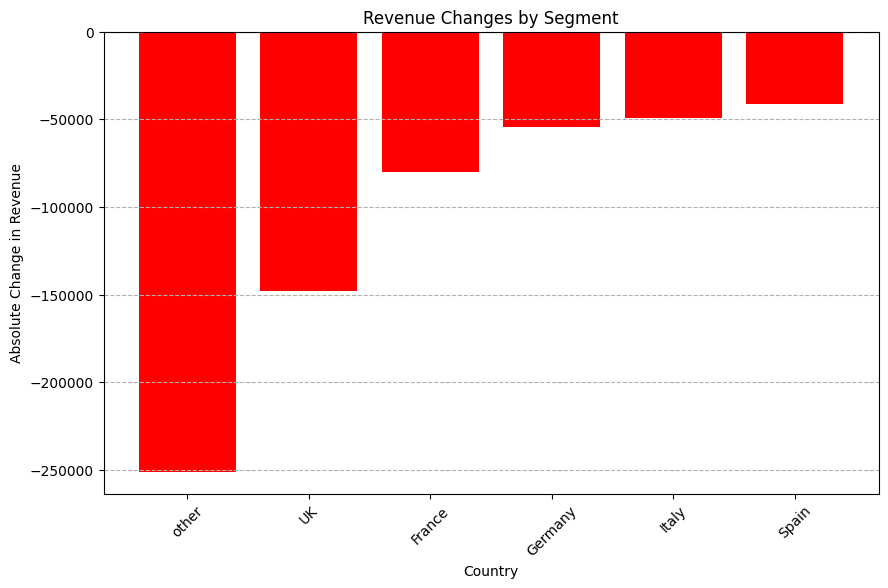

In [63]:
task = """
Here is a pandas dataframe showing revenue by segment, comparing values before and after. 

Your task will be understand the changes to the revenue (after vs before) in different segments and provide executive summary.
Please, follow the following steps:
1. Estimate how the total revenue and the revenue for each segment have changed, both in absolute terms and as a percentage.
2. Calculate the contribution of each segment to the total change in revenue.
3. Create an image for a chart to show the changes of the main metric. 
4. Summarise the insights based on data and provide executive summary.

Round all floating-point numbers in the output to two decimal places. 
"""
agent.logger.level = 1 # Lower verbosity level
agent.run(
    task,
    additional_args={"df": df},
)

In [16]:
import pandas as pd 
import numpy as np 
import random
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = "simple_white"

import pandas as pd 
import numpy as np 
import random
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = "simple_white"

# visualisations

def create_share_vs_impact_chart(df, dimension, share_field, impact_field):
    """
    Creates an interactive scatter plot chart using Plotly to compare the size of the segments vs its impact on the metric change
    
    Parameters:
    -----------
    df : pandas DataFrame
        Data containing share 
    dimension : str
        Column name of the parameter/segment variable
    share_field : str
        Column name for the share of segment values
    impact_field : str
        Column name for the impact on the metric change values
    """
    plot_df = df.copy() # cloning df for manipulations
    plot_df['impact_norm'] = plot_df[impact_field]/plot_df[share_field]

    colorscale = px.colors.qualitative.D3
    fig = go.Figure()
    
    # Add scatter plot with conditional colors
    for i, row in plot_df.iterrows():
        marker_color = colorscale[2] if row['impact_norm'] > 1.5 else (colorscale[3] if row['impact_norm'] < -0.5 else colorscale[0]) 
        
        fig.add_trace(go.Scatter(
            x=[row[share_field]],
            y=[row[impact_field]],
            mode='markers',
            marker=dict(
                size=10,  # Larger marker size
                color=marker_color,
                opacity=0.75
            ),
            showlegend=False
        ))
    
    
    # Add the x=y reference line
    max_val = max(max(plot_df[share_field].values), max(plot_df[impact_field].values))
    min_val = min(min(plot_df[share_field].values), min(plot_df[impact_field].values))
    line_range = [min_val, max_val]
    
    fig.add_trace(
        go.Scatter(
            x=line_range,
            y=line_range,
            mode="lines",
            line=dict(dash="dash", color="gray", width=1.5),
        )
    )

    # Add annotations to the chart
    for i, row in plot_df.iterrows():
        fig.add_annotation(
            x=row[share_field],
            y=row[impact_field],
            text=f"{row[dimension]}",
            showarrow=False,
            xanchor='center',   
            yanchor='bottom',  
            font=dict(size=10),
            yshift=5,  
        )
    
    # Show the plot
    fig.update_layout(
        title="<b>Metric change explained:</b> correlation between segment size and impact on the change",
        xaxis_title="Share of segment before, %",
        yaxis_title="Share in difference, %",
        template="simple_white",
        height=600,
        width=800, 
        showlegend = False)
    fig.show()

def create_parallel_coordinates_chart(df, dimension, before_field='before', 
                                      after_field='after', impact_norm_field = 'impact_norm', metric_name = '', show_mean = False):
    """
    Creates an interactive parallel coordinates chart using Plotly
    
    Parameters:
    -----------
    df : pandas DataFrame
        Data containing before/after values per segment
    dimension : str
        Column name of the parameter/segment variable
    before_field : str
        Column name for the 'before' values
    after_field : str
        Column name for the 'after' values
    impact_norm_field : str
        Column name for the normalised impact coefficient values (the ratio of impact to the segment size)
    """
    # Create a copy of the dataframe for manipulation
    plot_df = df.copy()
    plot_df = plot_df.sort_values(impact_norm_field, ascending = False)
    
    # Define color mapping for params
    dimensions = plot_df[dimension].unique()
    if df.shape[0] <= 10:
        colorscale = px.colors.qualitative.D3
    else:
        colorscale = px.colors.qualitative.Dark24
    colors = [colorscale[i % len(colorscale)] for i in range(len(dimensions))]
    color_map = dict(zip(dimensions, colors))
    plot_df['color'] = plot_df[dimension].map(color_map)
    
    # Create accents on meaningful changes using line width and opacity
    plot_df['line_width'] = plot_df[impact_norm_field].map(
        lambda x: 4 if (x > 1.5) or (x < -0.5) else 2
    )
    plot_df['opacity'] = plot_df[impact_norm_field].map(
        lambda x: 1 if (x > 1.5) or (x < -0.5) else 0.6
    )
    
    # Create the figure
    fig = go.Figure()

    if show_mean:
        # Calculate mean values for reference line
        mean_before = plot_df[before_field].mean()
        mean_after = plot_df[after_field].mean()
        
        # Add mean reference line
        fig.add_trace(
            go.Scatter(
                x=['BEFORE', 'AFTER'],
                y=[mean_before, mean_after],
                mode='lines',
                line=dict(color='gray', width=1.5, dash='dash'),
                opacity=0.7,
                name='Average',
                showlegend=False # remove from legend
            )
        )
    
    # Add lines for each parameter value
    for idx, row in plot_df.iterrows():
        fig.add_trace(
            go.Scatter(
                x=['BEFORE', 'AFTER'],
                y=[row[before_field], row[after_field]],
                mode='lines+markers',
                line=dict(
                    color=row['color'],
                    width=row['line_width']
                ),
                opacity=row['opacity'],
                name=f"{row[dimension]}",
                marker=dict(size=8),
            )
        )
    
    # Update layout
    if metric_name != '':
        metric_title = ', ' + metric_name
    else: 
        metric_title = ''
    fig.update_layout(
        title= '<b>Metric change explained:</b> before vs after' + metric_title,
        xaxis=dict(
            showgrid=False,
            tickfont=dict(size=12, weight='bold')
        ),
        yaxis=dict(
            title='Value',
            showgrid=True,
            gridcolor='rgba(211, 211, 211, 0.7)',
            gridwidth=1,
            tickformat='.0s'  # Automatically format large numbers (K, M)
        ),
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=-0.25,
            xanchor='center',
            x=0.5,
            font=dict(size=10)
        ),
        plot_bgcolor='white',
        width=800,
        height=600,
        margin=dict(l=60, r=30, t=80, b=120)
    )
    
    fig.show()

def hex_to_rgba(hex_color, alpha=None):
    hex_color = hex_color.lstrip('#')
    rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    if alpha is not None:
        return f"rgba({rgb[0]}, {rgb[1]}, {rgb[2]}, {alpha})"
    else:
        return f"rgb({rgb[0]}, {rgb[1]}, {rgb[2]})"

# analysis
@tool 
def calculate_simple_growth_metrics(df: pd.DataFrame, dimension: str) -> pd.DataFrame:
    """
    Provides analysis of the change of simple metrics before and after by specified segment. 
    Calculates the top line impact and stats by segment and creates charts to show the impact
    
    Args:
        df: data frame with columns "before" and "after" that we're analysing
        dimension: column that defines the segment to analyse the metric change
    """
    stats_df = df.groupby(dimension, as_index = True)[['before', 'after']].sum()
    # Calculating overall stats
    before = stats_df.before.sum()
    after = stats_df.after.sum()
    print('Metric change: %.2f -> %.2f (%.2f%%)' % (before, after, 100*(after - before)/before))

    # Estimating impact of each segment
    stats_df['difference'] = stats_df.after - stats_df.before
    stats_df['difference_rate'] = (100*stats_df.difference/stats_df.before).map(lambda x: round(x, 2))
    stats_df['impact'] = (100*stats_df.difference / stats_df.difference.sum()).map(lambda x: round(x, 2))
    stats_df['segment_share_before'] = (100* stats_df.before / stats_df.before.sum()).map(lambda x: round(x, 2))
    stats_df['impact_norm'] = (stats_df.impact/stats_df.segment_share_before).map(lambda x: round(x, 2))
    # stats_df['abs_impact_norm'] = stats_df.impact_norm.map(abs)

    # Sorting based on the impact normed on the size
    # stats_df = stats_df.sort_values('abs_impact_norm', ascending = False)
    # stats_df = stats_df.drop('abs_impact_norm', axis = 1)

    # Creating visualisations
    create_parallel_coordinates_chart(stats_df.reset_index(), stats_df.index.name)
    create_share_vs_impact_chart(stats_df.reset_index(), stats_df.index.name, 'segment_share_before', 'impact')
    
    return stats_df.sort_values('impact_norm', ascending = False)

In [18]:
agent.tools

{'calculate_simple_growth_metrics': <smolagents.tools.tool.<locals>.SimpleTool at 0x1557e3910>,
 'final_answer': <smolagents.default_tools.FinalAnswerTool at 0x125316790>}

In [19]:
raw_df = pd.read_csv('absolute_metrics_example.csv', sep = '\t')
df = raw_df.groupby(['country', 'maturity'], as_index = False)[['revenue_before', 'revenue_after_scenario_1']].sum()\
        .sort_values('revenue_before', ascending = False).rename(
            columns = {'revenue_after_scenario_1': 'after', 'revenue_before': 'before'}
        )
df

,country,maturity,before,after
10,other,existing,398808.97,309044.33
8,UK,existing,353085.05,298405.57
11,other,new,233958.42,72666.89
0,France,existing,182802.72,143202.12
9,UK,new,128324.22,34838.87
2,Germany,existing,112363.92,92276.92
4,Italy,existing,83410.74,59691.42
6,Spain,existing,63887.76,47302.12
1,France,new,57901.91,17443.06
3,Germany,new,48105.83,13678.94


'{"calculate_simple_growth_metrics": "Provides analysis of the change of simple metrics before and after by specified segment. \\nCalculates the top line impact and stats by segment and creates charts to show the impact", "final_answer": "Provides a final answer to the given problem."}'

In [24]:
# calculate_simple_growth_metrics(df, 'country')

In [72]:
events = [
  {
    "change_date": "2025-04-02",
    "description": "Launched new express delivery option in Germany, improving estimated delivery times by 30%."
  },
  {
    "change_date": "2025-04-05",
    "description": "UK postal service strike caused significant delays in order deliveries, potentially increasing cancellation and refund rates."
  },
  {
    "change_date": "2025-04-09",
    "description": "Rolled out redesigned mobile app interface globally, expected to influence user engagement and conversion on mobile."
  },
  {
    "change_date": "2025-04-11",
    "description": "France introduced new consumer protection law requiring more detailed return policies on product pages, potentially impacting conversion."
  },
  {
    "change_date": "2025-04-15",
    "description": "Search algorithm update deployed across all platforms to improve product discovery based on user behavior."
  },
  {
    "change_date": "2025-04-17",
    "description": "Italy experienced a payment gateway outage for several hours, affecting transaction completion rates."
  },
  {
    "change_date": "2025-04-19",
    "description": "Promotional campaign launched targeting small countries, with a 20% discount on electronics category."
  },
  {
    "change_date": "2025-04-22",
    "description": "Spain's VAT rate for online goods increased by 2%, potentially impacting pricing competitiveness and cart abandonment."
  },
  {
    "change_date": "2025-04-25",
    "description": "Introduced carbon-neutral shipping option across all EU markets; early opt-in rates may affect delivery choices."
  },
  {
    "change_date": "2025-04-28",
    "description": "Major influencer collaboration launched in the UK and France for fashion category, expected to increase traffic and sales."
  },
  {
    "change_date": "2025-05-01",
    "description": "Labour Day public holiday observed in most EU countries, affecting warehouse operations and shipping timelines."
  },
  {
    "change_date": "2025-05-03",
    "description": "Launched a multilingual chatbot for customer support in France and Italy, aimed at reducing ticket resolution time."
  },
  {
    "change_date": "2025-05-06",
    "description": "Germany rolled out new packaging regulations impacting product listings with insufficient recycling information, minor impact"
  },
{
    "change_date": "2025-05-08",
    "description": "Introduced new controls at onboarding stage to reduce the number of bad customers and potential fraud, that caused significant drop of 70% in number of new users and revenue"
  },
  {
    "change_date": "2025-05-09",
    "description": "Major system upgrade completed on checkout backend across all countries; minor downtime recorded in small regions."
  },
  {
    "change_date": "2025-05-12",
    "description": "Introduced loyalty points system in Spain and the UK, potentially boosting repeat purchase rates."
  },
  {
    "change_date": "2025-05-14",
    "description": "France experienced a temporary spike in failed transactions due to new banking API requirements, minor impact on active users."
  },
  {
    "change_date": "2025-05-18",
    "description": "New seasonal marketing campaign launched in all countries, featuring regional language creatives and country-specific product bundles."
  },
  {
    "change_date": "2025-05-21",
    "description": "Warehouse automation enhancements went live in Italy and Germany, expected to improve fulfillment speed KPIs."
  },
  {
    "change_date": "2025-05-30",
    "description": "UK implemented new digital advertising restrictions targeting minors, potentially impacting ad campaign performance."
  }
]
events_df = pd.DataFrame(events)

events_df['month'] = events_df.change_date.map(
    lambda x: '-'.join(x.split('-')[:2]) + '-01'
)

events_df

,change_date,description,month
0,2025-04-02,Launched new express delivery option in German...,2025-04-01
1,2025-04-05,UK postal service strike caused significant de...,2025-04-01
2,2025-04-09,Rolled out redesigned mobile app interface glo...,2025-04-01
3,2025-04-11,France introduced new consumer protection law ...,2025-04-01
4,2025-04-15,Search algorithm update deployed across all pl...,2025-04-01
5,2025-04-17,Italy experienced a payment gateway outage for...,2025-04-01
6,2025-04-19,Promotional campaign launched targeting small ...,2025-04-01
7,2025-04-22,Spain's VAT rate for online goods increased by...,2025-04-01
8,2025-04-25,Introduced carbon-neutral shipping option acro...,2025-04-01
9,2025-04-28,Major influencer collaboration launched in the...,2025-04-01


In [73]:
@tool 
def get_change_log(month: str) -> str: 
    """
    Returns the change log (list of internal and external events that might have affected our KPIs) for the given month 

    Args:
        month: month in the format %Y-%m-01, for example, 2025-04-01
    """
    return events_df[events_df.month == month].drop('month', axis = 1).to_dict('records')

In [112]:
model = LiteLLMModel(model_id="openai/gpt-4o", api_key=config['OPENAI_API_KEY'])
hange_log_agent = ToolCallingAgent(
    tools=[get_change_log],
    model=model,
    max_steps=10,
    name="change_log_agent",
    description="Helps you find the relevant information in the change log that can explain changes on metrics. Provide the agent with all the context to receive info",
)

change_log_system_prompt = '''
You're a master of the change log and you help others to explain the changes to metrics. 
When you receive a request, look up the list of events happened by month, then filter the relevant information based 
on provided context and return back. Prioritise the most probable factors affecting the KPI and limit your answer only to them.
'''

agent.logger.console.width=66
modified_system_prompt = change_log_agent.prompt_templates['system_prompt'] + '\n\n\n' + change_log_system_prompt

change_log_agent.prompt_templates['system_prompt'] = modified_system_prompt

In [113]:
# change_log_agent.run(
#     "What happened in May 2025 that caused drop in the revenue from new customers?"
# )

In [114]:
model = LiteLLMModel(model_id="openai/gpt-4.1-mini", api_key=config['OPENAI_API_KEY']) 
agent = CodeAgent(
    model=model,
    tools=[calculate_simple_growth_metrics],
    max_steps=20,
    additional_authorized_imports=["pandas", "numpy", "matplotlib.*", "plotly.*"],
    verbosity_level = 2, # lower verbosity level
    planning_interval = 3,
    managed_agents = [change_log_agent]
)
agent.logger.console.width=66
modified_system_prompt = agent.prompt_templates['system_prompt']\
    .replace(
        '2. Use only variables that you have defined!', 
        '2. Use only variables that you have defined or ones provided in additional arguments! Never try to copy and parse additional arguments.'
    )
agent.prompt_templates['system_prompt'] = modified_system_prompt

In [115]:
tools_dict = {}
for t in agent.tools:
    tools_dict[t] = agent.tools[t].description

tools_description = json.dumps(tools_dict)
tools_description

'{"calculate_simple_growth_metrics": "Provides analysis of the change of simple metrics before and after by specified segment. \\nCalculates the top line impact and stats by segment and creates charts to show the impact", "final_answer": "Provides a final answer to the given problem."}'

╭─────────────────────────── New run ────────────────────────────╮
│                                                                │
│ Here is a pandas dataframe showing the revenue by segment,     │
│ comparing values before (April 2025) and after (May 2025).     │
│                                                                │
│ You're a senior and experienced data analyst. Your task will   │
│ be understand the changes to the revenue (after vs before) in  │
│ different segments                                             │
│ and provide executive summary.                                 │
│                                                                │
│ ## Follow the plan:                                            │
│ 1. Start by udentifying the list of dimensions (columns in     │
│ dataframe that are not "before" and "after")                   │
│ 2. There might be multiple dimensions in the dataframe. Start  │
│ high-level by looking at each dimension in isolation, combine  │
│ all results                                                    │
│ together into the list of segments analysed (don't forget to   │
│ save the dimension used for each segment).                     │
│ Use the provided tools to analyse the changes of metrics:      │
│ {"calculate_simple_growth_metrics": "Provides analysis of the  │
│ change of simple metrics before and after by specified         │
│ segment. \nCalculates the top line impact and stats by segment │
│ and creates charts to show the impact", "final_answer":        │
│ "Provides a final answer to the given problem."}.              │
│ 3. Analyse the results from previous step and keep only        │
│ segments that have outsized impact on the KPI change (absolute │
│ of impact_norm is above 1.25).                                 │
│ 4. Check what dimensions are present in the list of            │
│ significant segment, if there are multiple ones - execute the  │
│ tool on their combinations                                     │
│ and add to the analysed segments. If after adding an           │
│ additional dimension, all subsegments show close               │
│ different_rate and impact_norm values,                         │
│ then we can exclude this split (even though impact_norm is     │
│ above 1.25), since it doesn't explain anything.                │
│ 5. Summarise the significant changes you identified.           │
│ 6. Try to explain what is going on with metrics by getting     │
│ info from the change_log_agent. Please, provide the agent the  │
│ full context                                                   │
│ (what segments have outsized impact, what is the relative      │
│ change and what is the period we're looking at).               │
│ Summarise the information from the changelog and mention only  │
│ 1-3 the most probable causes of the KPI change (starting from  │
│ the most impactful one).                                       │
│ 7. Put together 3-5 sentences commentary what happened         │
│ high-level and why (based on the info received from the change │
│ log).                                                          │
│ Then follow it up with more detailed summary:                  │
│ - Top-line total value of metric before and after in           │
│ human-readable format, absolute and relative change            │
│ - List of segments that meaningfully influenced the metric     │
│ positively or negatively with the following numbers: values    │
│ before and after,                                              │
│ absoltue and relative change, share of segment before, impact  │
│ and normed impact. Order the segments by absolute value of     │
│ absolute change since                                          │
│ it represents the power of impact.                             │
│                                                                │
│ ## Instruction on the calculate_simple_growth_metrics tool:    │
│ By default, you should use the tool for the w

────────────────────────── Initial plan ──────────────────────────
Here are the facts I know and the plan of action that I will 
follow to solve the task:
```
## 1. Facts survey

### 1.1. Facts given in the task
- We have a pandas dataframe `df` showing revenue by segment, for 
two time points: before (April 2025) and after (May 2025).
- The dataframe columns include:
  - Dimensions: `country`, `maturity`, `country_maturity`, 
`country_maturity_combined`
  - Metrics: `before` (revenue in April 2025), `after` (revenue in
May 2025)
- The task is to understand the changes in revenue (after vs 
before) across different segments.
- Key instructions and tools provided:
  - Identify all dimensions except before/after for segmentation.
  - Analyze each dimension independently using 
`calculate_simple_growth_metrics`.
  - Filter segments with outsized impact on KPI change (absolute 
normed impact > 1.25).
  - Examine combinations of dimensions if multiple dimensions have
significant segments.
  - Summarize significant changes and engage `change_log_agent` 
for contextual causes.
  - Provide a final executive summary including top-line changes 
and segment-level detailed impacts.
- Dataset snippet shows segments combining countries (`France`, 
`UK`, `Germany`, `Italy`, `Spain`, `other`) and maturity status 
(`new`, `existing`).
- The combined segments are uniquely identified in columns 
`country_maturity` and `country_maturity_combined`.

### 1.2. Facts to look up
- Definitions or descriptions of the segments if unclear (e.g., 
what defines `new` vs `existing` maturity).
  - Likely not mandatory to proceed, but could be requested from 
business documentation or change log.
- More details on the change log (accessible via 
`change_log_agent`) that could provide probable causes for revenue
changes.
- Confirmation on handling combined dimension splits — how exactly
`country_maturity_combined` is formed and should be interpreted in
combined dimension analysis.
- Data dictionary or description of metrics if any additional KPI 
besides revenue is relevant (unlikely given data).
- Dates confirm period of analysis: April 2025 (before) and May 
2025 (after). No need to look these up since given.

### 1.3. Facts to derive
- Identify all dimension columns available for segmentation:
  - By excluding 'before' and 'after', likely candidates are 
`country`, `maturity`, `country_maturity`, and 
`country_maturity_combined`.
- For each dimension, calculate change metrics using the given 
tool:
  - Absolute and relative difference in revenue per segment.
  - Impact, segment share before, and normed impact for each 
segment.
- Identify which segments have outsized impact on KPI change 
(|impact_norm| > 1.25).
- If multiple dimensions have significant segments, combine 
dimensions (e.g., country + maturity) and reanalyze.
- Determine if combined dimension splits provide meaningful 
differentiation or not, based on delta rate and impact_norm 
consistency.
- Summarize direction and magnitude of KPI changes at top-line 
level (aggregate revenue before and after).
- Identify top segments driving positive and negative changes 
based on ordered absolute absolute_change.
- Gather contextual insights from the change log agent regarding 
probable causes tied to significant segments and the May 2025 vs 
April 2025 period.

## 2. Plan

1. Identify all dimension columns present in the dataframe by 
listing columns and excluding 'before' and 'after'.
2. For each dimension identified (`country`, `maturity`, 
`country_maturity`, `country_maturity_combined`):
   - Use `calculate_simple_growth_metrics` on the full dataframe 
grouped by that dimension.
   - Extract segments with calculated metrics including 
impact_norm.
3. Aggregate results from all single-dimension analyses and filter
segments where |impact_norm| > 1.25.
4. Determine which dimensions these significant segments belong 
to.
5. If more than one dimension is represented in these significant 
segments, analyze

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ───────────────────────────────────────
Thought: I will start by identifying the dimensions available in  
the dataframe, which are the columns excluding 'before' and       
'after'. Then I will run the tool                                 
`calculate_simple_growth_metrics` on the whole dataset for each of
these dimensions to analyze the changes in revenue.               
                                                                  
Code:                                                             
```py                                                             
# Identify dimension columns excluding 'before' and 'after'       
dimensions = [col for col in df.columns if col not in ['before',  
'after']]                                                         
print("Dimensions to analyze:", dimensions)                       
                                                                  
# For each dimension, run the calculate_simple_growth_metrics tool
and print the results                                             
for dim in dimensions:                                            
    print(f"Results for dimension '{dim}':")                      
    metrics = calculate_simple_growth_metrics(df=df,              
dimension=dim)                                                    
    print(metrics)                                                
    print("\n" + "="*80 + "\n")                                   
```                                                               

─ Executing parsed code: ─────────────────────────────────────── 
  # Identify dimension columns excluding 'before' and 'after'     
  dimensions = [col for col in df.columns if col not in           
  ['before', 'after']]                                            
  print("Dimensions to analyze:", dimensions)                     
                                                                  
  # For each dimension, run the calculate_simple_growth_metrics   
  tool and print the results                                      
  for dim in dimensions:                                          
      print(f"Results for dimension '{dim}':")                    
      metrics = calculate_simple_growth_metrics(df=df,            
  dimension=dim)                                                  
      print(metrics)                                              
      print("\n" + "="*80 + "\n")                                 
 ────────────────────────────────────────────────────────────────

Metric change: 1731985.21 -> 1107924.43 (-36.03%)


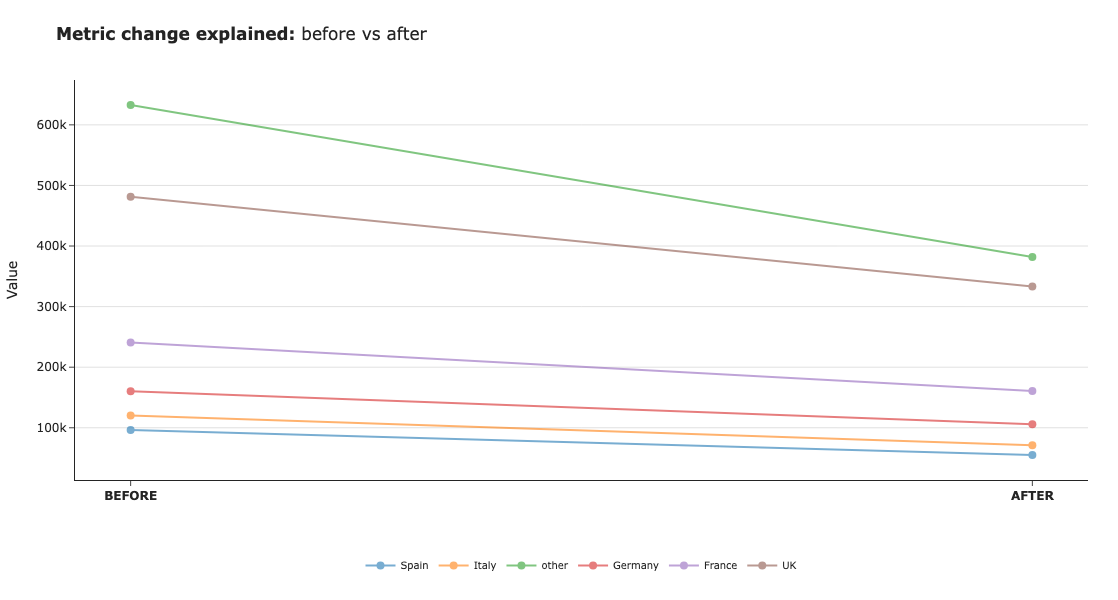

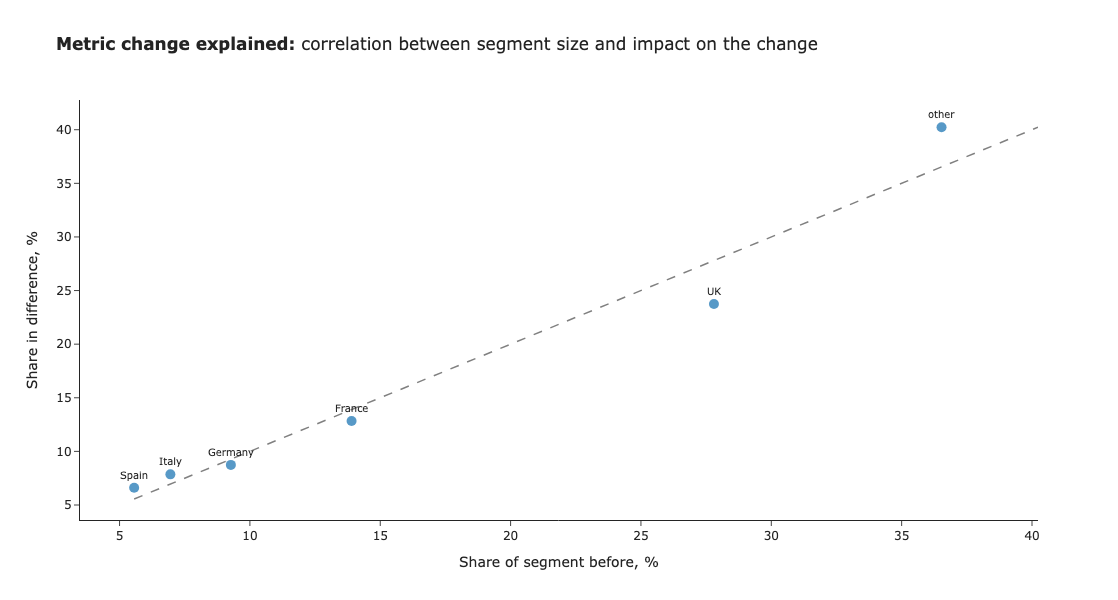

Metric change: 1731985.21 -> 1107924.43 (-36.03%)


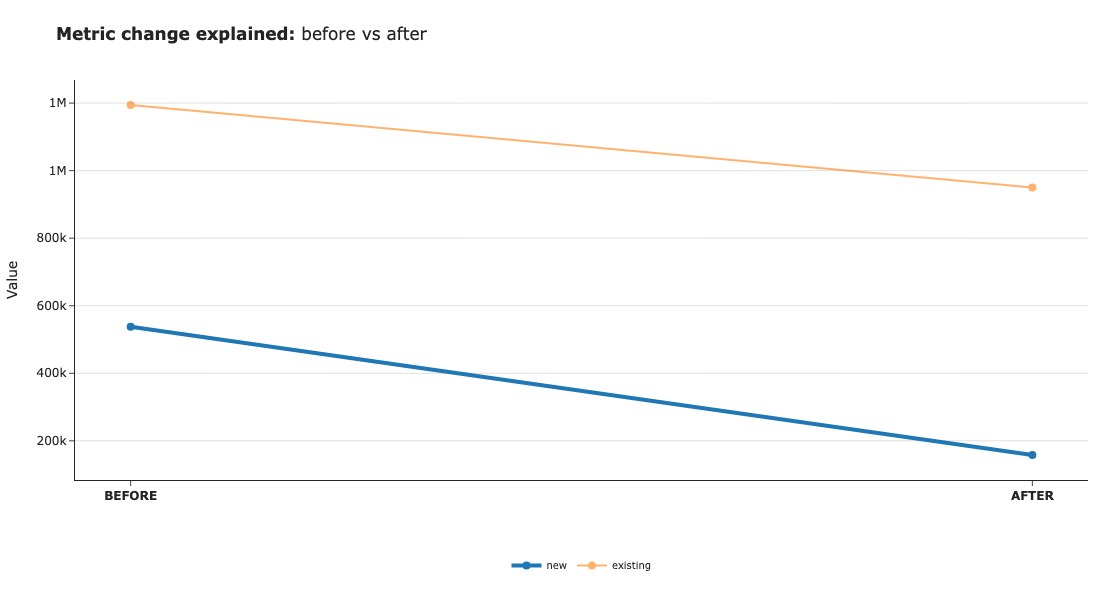

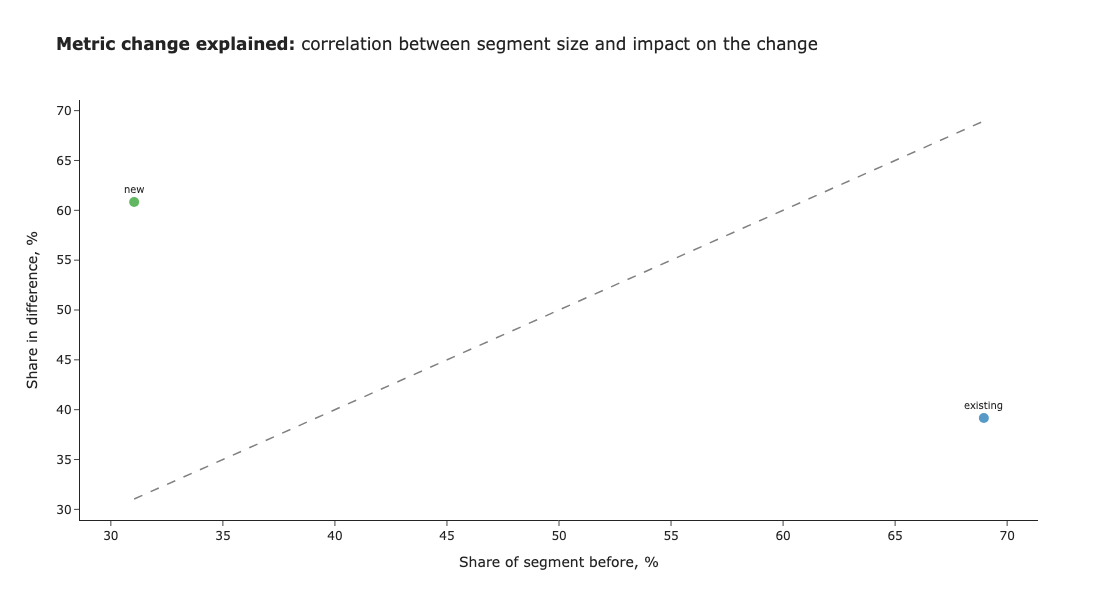

Metric change: 1731985.21 -> 1107924.43 (-36.03%)


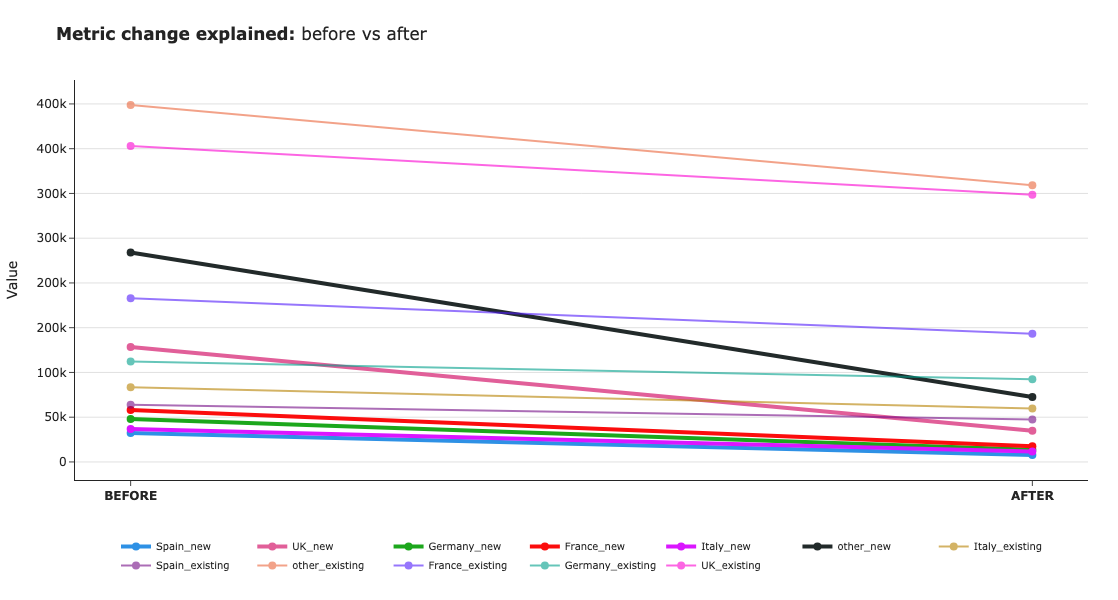

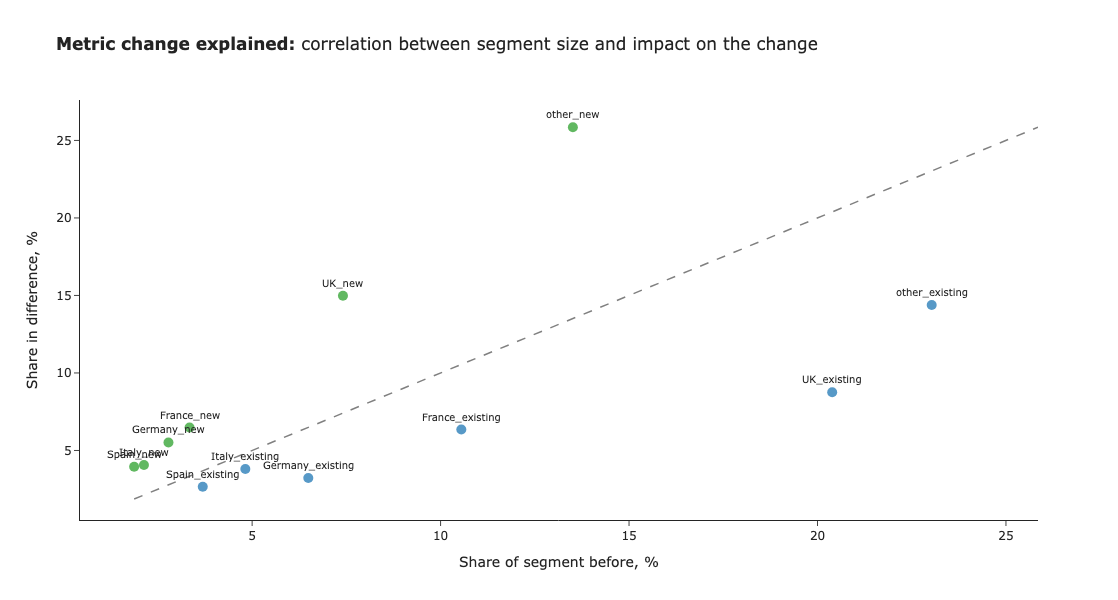

Metric change: 1731985.21 -> 1107924.43 (-36.03%)


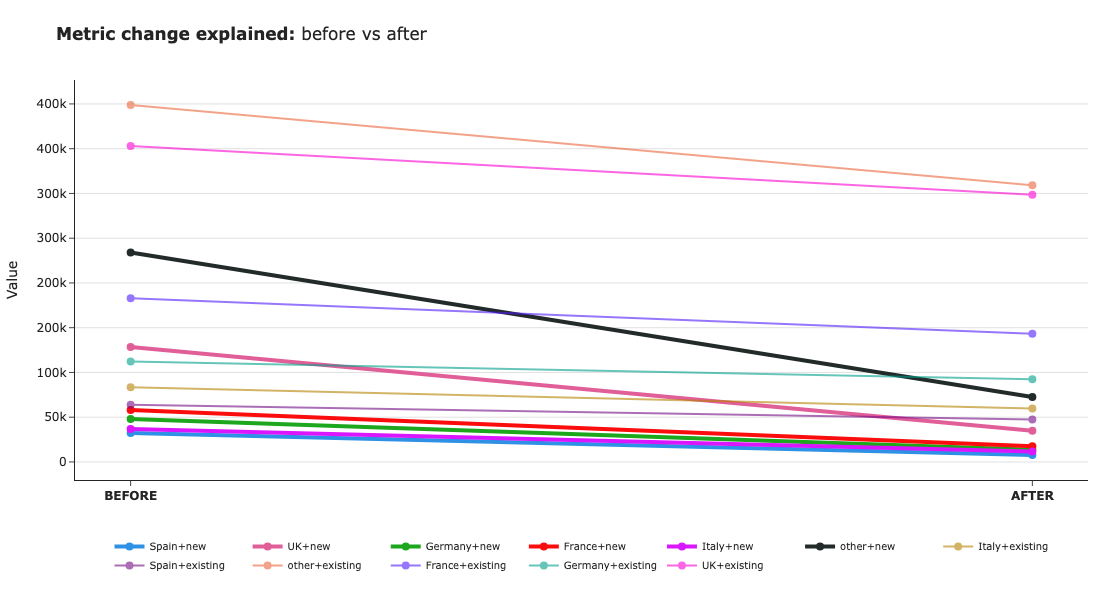

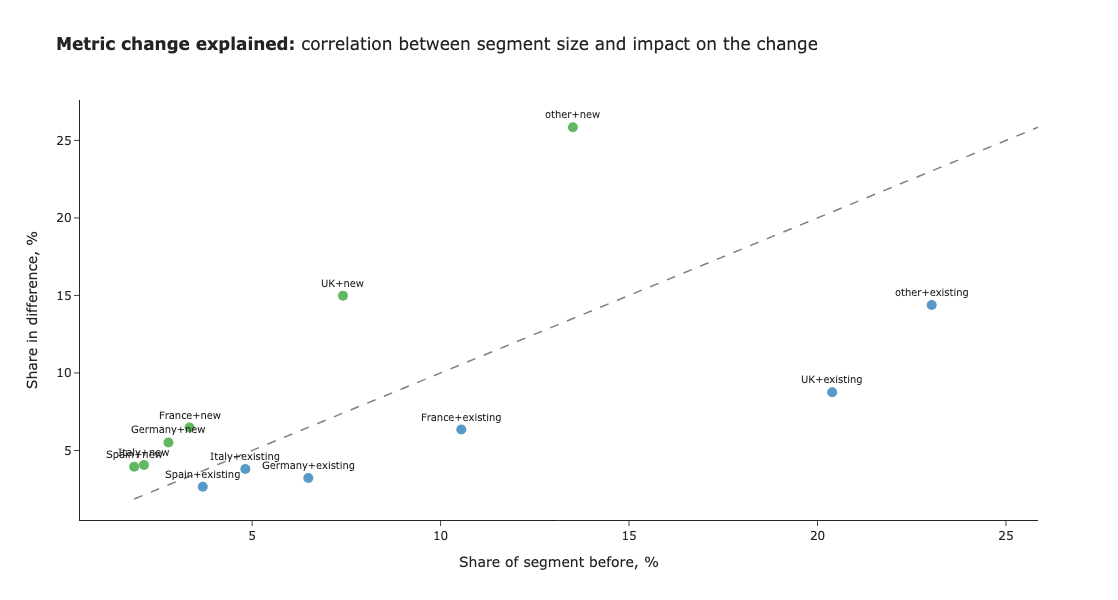

Execution logs:
Dimensions to analyze: ['country', 'maturity', 'country_maturity',
'country_maturity_combined']
Results for dimension 'country':
            before      after  difference  difference_rate  impact
\
country                                                           
Spain     96281.86   55061.02   -41220.84           -42.81    6.61
Italy    120352.31   71306.71   -49045.60           -40.75    7.86
other    632767.39  381711.22  -251056.17           -39.68   40.23
Germany  160469.75  105955.86   -54513.89           -33.97    8.74
France   240704.63  160645.18   -80059.45           -33.26   12.83
UK       481409.27  333244.44  -148164.83           -30.78   23.74

         segment_share_before  impact_norm  
country                                     
Spain                    5.56         1.19  
Italy                    6.95         1.13  
other                   36.53         1.10  
Germany                  9.27         0.94  
France                  13.90         0.92  
UK                      27.80         0.85  

==================================================================
==============

Results for dimension 'maturity':
              before      after  difference  difference_rate  
impact  \
maturity                                                          
new        537626.05  158001.95  -379624.10           -70.61   
60.83   
existing  1194359.16  949922.48  -244436.68           -20.47   
39.17   

          segment_share_before  impact_norm  
maturity                                     
new                      31.04         1.96  
existing                 68.96         0.57  

==================================================================
==============

Results for dimension 'country_maturity':
                     before      after  difference  
difference_rate  impact  \
country_maturity                                                  
Spain_new          32394.10    7758.90   -24635.20           
-76.05    3.95   
UK_new            128324.22   34838.87   -93485.35           
-72.85   14.98   
Germany_new        48105.83   13678.94   -34426.89           
-71.56    5.52   
France_new         57901.91   17443.06   -40458.85           
-69.87    6.48   
Italy_new          36941.57   11615.29   -25326.28           
-68.56    4.06   
other_new         233958.42   72666.89  -161291.53           
-68.94   25.85   
Italy_existing     83410.74   59691.42   -23719.32           
-28.44    3.80   
Spain_existing     63887.76   47302.12   -16585.64           
-25.96    2.66   
other_existing    398808.97  309044.33   -89764.64           
-22.51   14.38   
France_existing   182802.72  143202.12   -39600.60           
-21.66    6.35   
Germany_existing  112363.92   92276.92   -20087.00           
-17.88    3.22   
UK_existing       353085.05  298405.57   -54679.48           
-15.49    8.76   

                  segment_share_before  impact_norm  
country_maturity                                     
Spain_new                         1.87         2.11  
UK_new                            7.41         2.02  
Germany_new                       2.78         1.99  
France_new                        3.34         1.94  
Italy_new                         2.13         1.91  
other_new                        13.51         1.91  
Italy_existing                    4.82         0.79  
Spain_existing                    3.69         0.72  
other_existing                   23.03         0.62  
France_existing                  10.55         0.60  
Germany_existing                  6.49         0.50  
UK_existing                      20.39         0.43  

==================================================================
==============

Results for dimension 'country_maturity_combined':
                              before      after  difference  
difference_rate  \
country_maturity_combined                                         
Spain+new                   32394.10    7758.90   -24635.20       
-76.05   
UK+new           

[Step 1: Duration 19.74 seconds| Input tokens: 4,441 | Output 
tokens: 168]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ───────────────────────────────────────
Thought: From the calculated metrics on the different dimensions, 
significant segments with outsized impact (impact_norm absolute   
value > 1.25) are mostly connected to the 'maturity' dimension    
(new has an impact_norm of 1.96) and all the 'new' subsegments    
within the 'country_maturity' and the 'country_maturity_combined' 
dimensions. The 'country' dimension segments have impact_norm     
values below the 1.25 threshold, so they seem less impactful on   
their own.                                                        
                                                                  
The 'country_maturity' and 'country_maturity_combined' dimensions 
yield very similar results, so using the combined dimension here  
may not add further information compared to the simpler           
'country_maturity' split.                                         
                                                                  
I will now filter the segments with |impact_norm| > 1.25 from the 
'maturity' and 'country_maturity' results and summarize these     
significant segments including values before and after,           
differences, and impact measures. Then I'll see if further        
dimension combination analysis is needed (not likely because      
'country_maturity' already combines country and maturity).        
                                                                  
Next step: Extract significant segments from both 'maturity' and  
'country_maturity', consolidate, and prepare data for next steps. 
                                                                  
Code:                                                             
```py                                                             
# Calculate metrics for maturity and country_maturity dimensions  
(already obtained, print filtered for significant segments)       
maturity_metrics = calculate_simple_growth_metrics(df=df,         
dimension='maturity')                                             
country_maturity_metrics = calculate_simple_growth_metrics(df=df, 
dimension='country_maturity')                                     
                                                                  
# Filter significant segments with |impact_norm| > 1.25 for       
maturity dimension                                                
significant_maturity [1

─ Executing parsed code: ─────────────────────────────────────── 
  # Calculate metrics for maturity and country_maturity           
  dimensions (already obtained, print filtered for significant    
  segments)                                                       
  maturity_metrics = calculate_simple_growth_metrics(df=df,       
  dimension='maturity')                                           
  country_maturity_metrics =                                      
  calculate_simple_growth_metrics(df=df,                          
  dimension='country_maturity')                                   
                                                                  
  # Filter significant segments with |impact_norm| > 1.25 for     
  maturity dimension                                              
  significant_maturity =                                          
  maturity_metrics.loc[maturity_metrics['impact_norm'].abs() >    
  1.25]                                                           
  print("Significant segments from 'maturity':")                  
  print(significant_maturity)                                     
                                                                  
  # Filter significant segments with |impact_norm| > 1.25 for     
  country_maturity dimension                                      
  significant_country_maturity =                                  
  country_maturity_metrics.loc[country_maturity_metrics['impact_  
  norm'].abs() > 1.25]                                            
  print("Significant segments from 'country_maturity':")          
  print(significant_country_maturity)                             
                                                                  
  # Combine the significant segments info for summary             
  print("\nSummary of all significant segments:")                 
  summary_segments =                                              
  significant_maturity.append(significant_country_maturity)       
  print(summary_segments)                                         
 ────────────────────────────────────────────────────────────────

Metric change: 1731985.21 -> 1107924.43 (-36.03%)


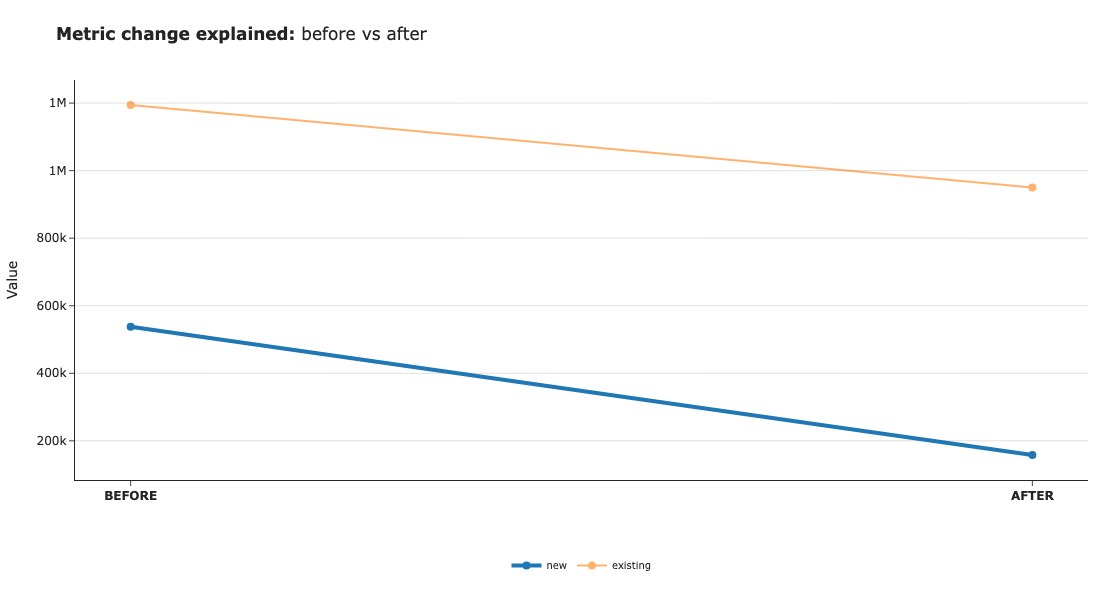

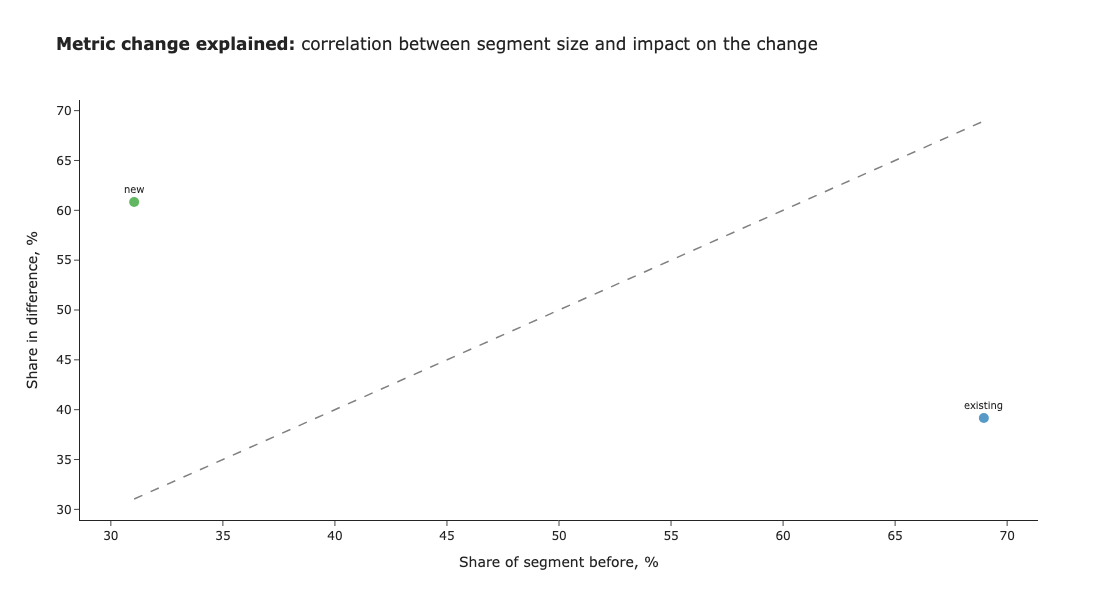

Metric change: 1731985.21 -> 1107924.43 (-36.03%)


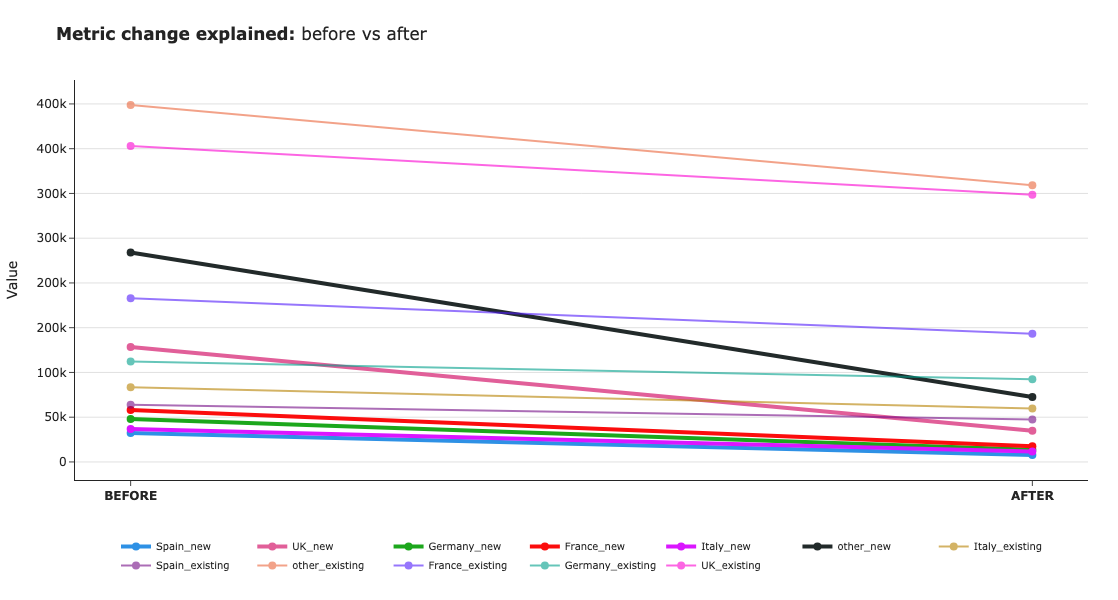

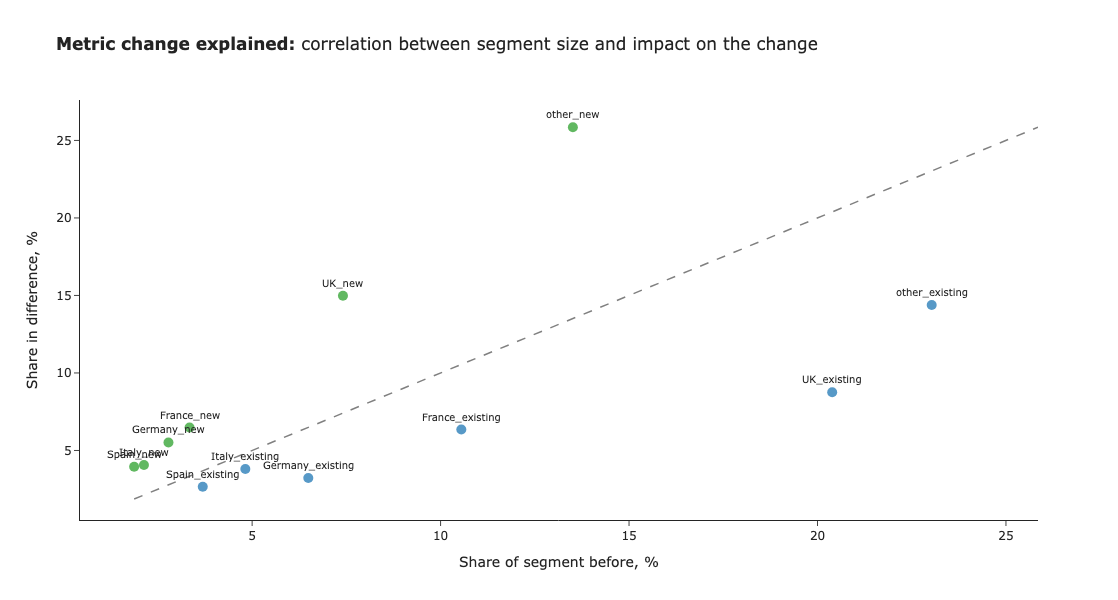

Execution logs:
Significant segments from 'maturity':
             before      after  difference  difference_rate  
impact  \
maturity                                                          
new       537626.05  158001.95   -379624.1           -70.61   
60.83   

          segment_share_before  impact_norm  
maturity                                     
new                      31.04         1.96  
Significant segments from 'country_maturity':
                     before     after  difference  difference_rate
impact  \
country_maturity                                                  
Spain_new          32394.10   7758.90   -24635.20           -76.05
3.95   
UK_new            128324.22  34838.87   -93485.35           -72.85
14.98   
Germany_new        48105.83  13678.94   -34426.89           -71.56
5.52   
France_new         57901.91  17443.06   -40458.85           -69.87
6.48   
Italy_new          36941.57  11615.29   -25326.28           -68.56
4.06   
other_new         233958.42  72666.89  -161291.53           -68.94
25.85   

                  segment_share_before  impact_norm  
country_maturity                                     
Spain_new                         1.87         2.11  
UK_new                            7.41         2.02  
Germany_new                       2.78         1.99  
France_new                        3.34         1.94  
Italy_new                         2.13         1.91  
other_new                        13.51         1.91  

Summary of all significant segments:

Code execution failed at line 'summary_segments = 
significant_maturity.append(significant_country_maturity)' due to:
InterpreterError: Object              before      after  
difference  difference_rate  impact  \
maturity                                                          
new       537626.05  158001.95   -379624.1           -70.61   
60.83   

          segment_share_before  impact_norm  
maturity                                     
new                      31.04         1.96   has no attribute 
append

[Step 2: Duration 9.64 seconds| Input tokens: 11,410 | Output 
tokens: 635]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ───────────────────────────────────────
Thought: The error happened because the pandas DataFrame returned 
by the tool might not be a typical DataFrame or does not have the 
'append' attribute. I will avoid using 'append' and instead       
concatenate the significant segments dataframes using             
pandas.concat. I will first import pandas as pd to use pandas     
concat safely.                                                    
                                                                  
Code:                                                             
```py                                                             
import pandas as pd                                               
                                                                  
# Combine significant segments using pd.concat instead of append  
summary_segments = pd.concat([significant_maturity,               
significant_country_maturity])                                    
print("Summary of all significant segments combined:")            
print(summary_segments)                                           
```                                                               

─ Executing parsed code: ─────────────────────────────────────── 
  import pandas as pd                                             
                                                                  
  # Combine significant segments using pd.concat instead of       
  append                                                          
  summary_segments = pd.concat([significant_maturity,             
  significant_country_maturity])                                  
  print("Summary of all significant segments combined:")          
  print(summary_segments)                                         
 ────────────────────────────────────────────────────────────────

Execution logs:
Summary of all significant segments combined:
                before      after  difference  difference_rate  
impact  \
new          537626.05  158001.95  -379624.10           -70.61   
60.83   
Spain_new     32394.10    7758.90   -24635.20           -76.05    
3.95   
UK_new       128324.22   34838.87   -93485.35           -72.85   
14.98   
Germany_new   48105.83   13678.94   -34426.89           -71.56    
5.52   
France_new    57901.91   17443.06   -40458.85           -69.87    
6.48   
Italy_new     36941.57   11615.29   -25326.28           -68.56    
4.06   
other_new    233958.42   72666.89  -161291.53           -68.94   
25.85   

             segment_share_before  impact_norm  
new                         31.04         1.96  
Spain_new                    1.87         2.11  
UK_new                       7.41         2.02  
Germany_new                  2.78         1.99  
France_new                   3.34         1.94  
Italy_new                    2.13         1.91  
other_new                   13.51         1.91  

Out: None

[Step 3: Duration 2.64 seconds| Input tokens: 19,660 | Output 
tokens: 753]

────────────────────────── Updated plan ──────────────────────────
I still need to solve the task I was given:
```

Here is a pandas dataframe showing the revenue by segment, 
comparing values before (April 2025) and after (May 2025). 

You're a senior and experienced data analyst. Your task will be 
understand the changes to the revenue (after vs before) in 
different segments 
and provide executive summary.

## Follow the plan:
1. Start by udentifying the list of dimensions (columns in 
dataframe that are not "before" and "after")
2. There might be multiple dimensions in the dataframe. Start 
high-level by looking at each dimension in isolation, combine all 
results 
together into the list of segments analysed (don't forget to save 
the dimension used for each segment). 
Use the provided tools to analyse the changes of metrics: 
{"calculate_simple_growth_metrics": "Provides analysis of the 
change of simple metrics before and after by specified segment. 
\nCalculates the top line impact and stats by segment and creates 
charts to show the impact", "final_answer": "Provides a final 
answer to the given problem."}. 
3. Analyse the results from previous step and keep only segments 
that have outsized impact on the KPI change (absolute of 
impact_norm is above 1.25). 
4. Check what dimensions are present in the list of significant 
segment, if there are multiple ones - execute the tool on their 
combinations 
and add to the analysed segments. If after adding an additional 
dimension, all subsegments show close different_rate and 
impact_norm values, 
then we can exclude this split (even though impact_norm is above 
1.25), since it doesn't explain anything. 
5. Summarise the significant changes you identified. 
6. Try to explain what is going on with metrics by getting info 
from the change_log_agent. Please, provide the agent the full 
context 
(what segments have outsized impact, what is the relative change 
and what is the period we're looking at). 
Summarise the information from the changelog and mention only 1-3 
the most probable causes of the KPI change (starting from the most
impactful one).
7. Put together 3-5 sentences commentary what happened high-level 
and why (based on the info received from the change log). 
Then follow it up with more detailed summary: 
- Top-line total value of metric before and after in 
human-readable format, absolute and relative change 
- List of segments that meaningfully influenced the metric 
positively or negatively with the following numbers: values before
and after, 
absoltue and relative change, share of segment before, impact and 
normed impact. Order the segments by absolute value of absolute 
change since 
it represents the power of impact. 

## Instruction on the calculate_simple_growth_metrics tool:
By default, you should use the tool for the whole dataset not the 
segment, since it will give you the full information about the 
changes.

Here is the guidance how to interpret the output of the tool
- difference - the absolute difference between after and before 
values
- difference_rate - the relative difference (if it's close for all
segments then the dimension is not informative)
- impact - the share of KPI differnce explained by this segment 
- segment_share_before - share of segment before
- impact_norm - impact normed on the share of segments, we're 
interested in very high or very low numbers since they show 
outsized impact, 
rule of thumb - impact_norm between -1.25 and 1.25 is 
not-informative 

If you're using the tool on the subset of dataframe keep in mind, 
thay the results won't be aplicable to the full dataset, so avoid 
using it 
unless you want to explicitly look at subset (i.e. change in 
France). If you decided to use the tool on a particular segment 
and share these results in the executive summary, explicitly 
outline that we're diving deeper into a particular segment.

You have been provided with these additional arguments available 
as variables with names df

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ───────────────────────────────────────
Thought: I will first check the 'country_maturity_combined'       
dimension to verify if the segments within the "new" maturity     
group show close difference_rate and impact_norm values (i.e. if  
they are homogeneous or not). If so, we will exclude this deeper  
split and stick with the 'country_maturity' level for significant 
change description. Then I will summarize the identified          
significant segments ordered by absolute value of absolute change 
for impact strength. After that, I will provide full context to   
the change_log_agent to understand the probable causes of the     
changes, and finally prepare an executive summary for             
presentation.                                                     
                                                                  
Code:                                                             
```py                                                             
# Check difference_rate and impact_norm for                       
country_maturity_combined new segments to see if they differ or   
are close                                                         
combined_metrics = calculate_simple_growth_metrics(df=df,         
dimension='country_maturity_combined')                            
new_combined_segments = combined_metrics.loc[[seg for seg in      
combined_metrics.index if 'new' in seg]]                          
                                                                  
print("New segments in country_maturity_combined dimension:")     
print(new_combined_segments[['difference_rate', 'impact_norm']])  
                                                                  
# If difference_rate and impact_norm are close, confirm           
homogeneity and proceed to summarize significant segments from    
country_maturity only                                             
max_diff_rate = new_combined_segments['difference_rate'].max()    
min_diff_rate = new_combined_segments['difference_rate'].min()    
max_impact_norm = new_combined_segments['impact_norm'].max()      
min_impact_norm = new_combined_segments['impact_norm'].min()      
                                                                  
print(f"Difference rate range among new combined segments:        
{min_diff_rate:.2f} to {max_diff_rate:.2f}")                      
print(f"Impact norm range among new combined segments:            
{

─ Executing parsed code: ─────────────────────────────────────── 
  # Check difference_rate and impact_norm for                     
  country_maturity_combined new segments to see if they differ    
  or are close                                                    
  combined_metrics = calculate_simple_growth_metrics(df=df,       
  dimension='country_maturity_combined')                          
  new_combined_segments = combined_metrics.loc[[seg for seg in    
  combined_metrics.index if 'new' in seg]]                        
                                                                  
  print("New segments in country_maturity_combined dimension:")   
  print(new_combined_segments[['difference_rate',                 
  'impact_norm']])                                                
                                                                  
  # If difference_rate and impact_norm are close, confirm         
  homogeneity and proceed to summarize significant segments from  
  country_maturity only                                           
  max_diff_rate = new_combined_segments['difference_rate'].max()  
  min_diff_rate = new_combined_segments['difference_rate'].min()  
  max_impact_norm = new_combined_segments['impact_norm'].max()    
  min_impact_norm = new_combined_segments['impact_norm'].min()    
                                                                  
  print(f"Difference rate range among new combined segments:      
  {min_diff_rate:.2f} to {max_diff_rate:.2f}")                    
  print(f"Impact norm range among new combined segments:          
  {min_impact_norm:.2f} to {max_impact_norm:.2f}")                
                                                                  
  # Prepare summary of significant segments from                  
  country_maturity dimension sorted by absolutedifference         
  significant_country_maturity_sorted =                           
  significant_country_maturity.copy()                             
  significant_country_maturity_sorted['abs_difference'] =         
  significant_country_maturity_sorted['difference'].abs()         
  significant_country_maturity_sorted =                           
  significant_country_maturity_sorted.sort_values(by='abs_differ  
  ence', ascending=False)                                         
                                                                  
  print("Significant segments sorted by absolute change:")        
  print(significant_country_maturity_sorted[['before', 'after',   
  'difference', 'difference_rate', 'segment_share_before',        
  'impact', 'impact_norm']])                                      
                                                                  
  # Total revenue before and after for top-line summary           
  total_before = df['before'].sum()                               
  total_after = df['after'].sum()                                 
  absolute_change = total_after - total_before                    
  relative_change = absolute_change / total_before * 100          
                                                                  
  print(f"Total revenue before: {total_before[38;2;230;219;116;48;2;

Metric change: 1731985.21 -> 1107924.43 (-36.03%)


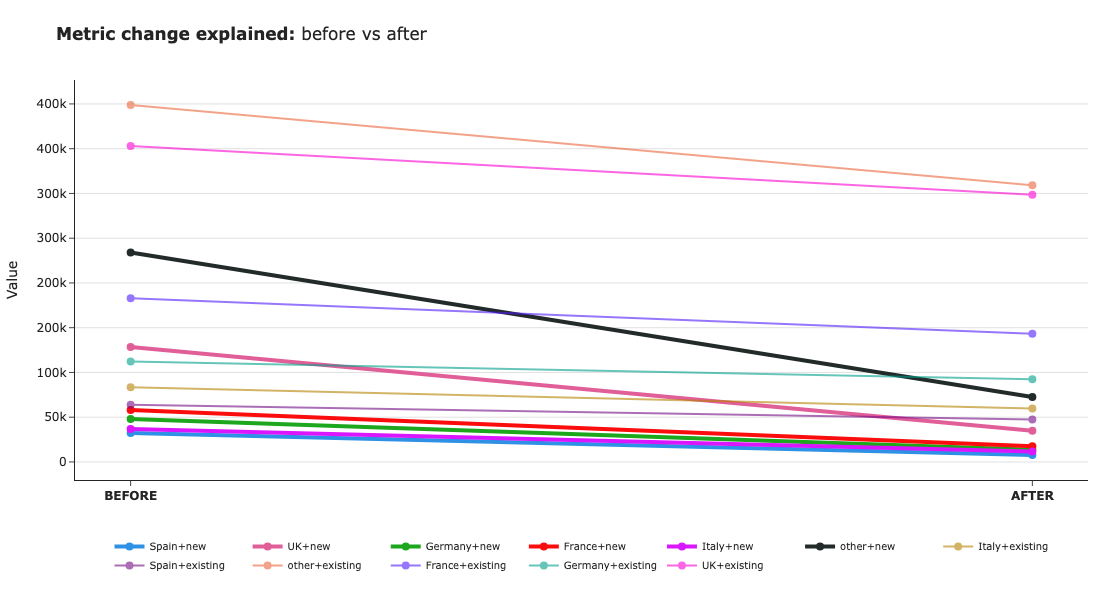

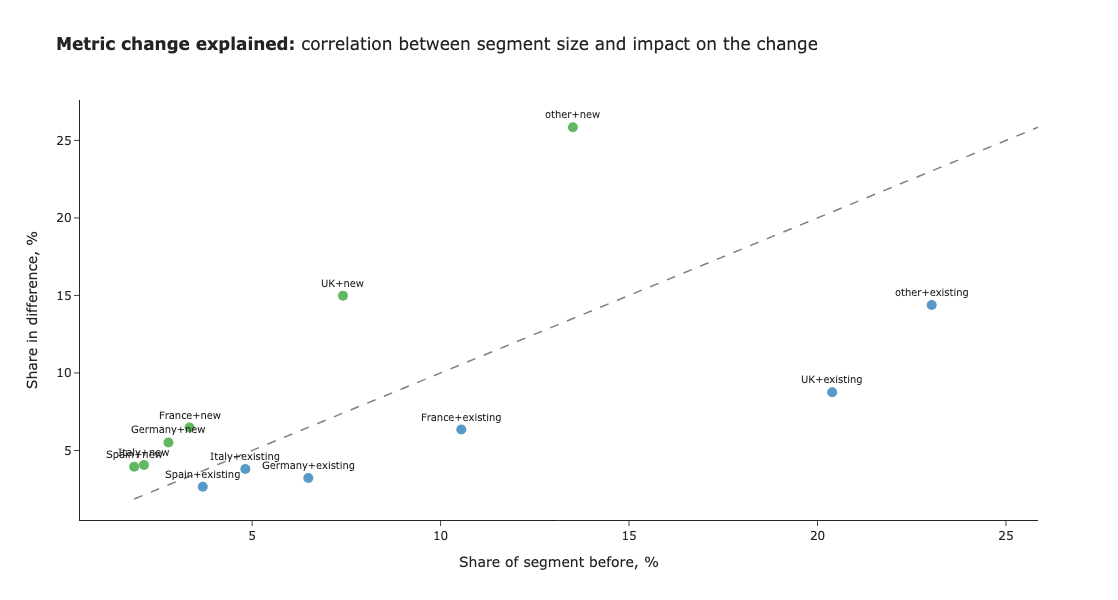

Execution logs:
New segments in country_maturity_combined dimension:
                           difference_rate  impact_norm
country_maturity_combined                              
Spain+new                           -76.05         2.11
UK+new                              -72.85         2.02
Germany+new                         -71.56         1.99
France+new                          -69.87         1.94
Italy+new                           -68.56         1.91
other+new                           -68.94         1.91
Difference rate range among new combined segments: -76.05 to 
-68.56
Impact norm range among new combined segments: 1.91 to 2.11
Significant segments sorted by absolute change:
                     before     after  difference  difference_rate
\
country_maturity                                                  
other_new         233958.42  72666.89  -161291.53           -68.94
UK_new            128324.22  34838.87   -93485.35           -72.85
France_new         57901.91  17443.06   -40458.85           -69.87
Germany_new        48105.83  13678.94   -34426.89           -71.56
Italy_new          36941.57  11615.29   -25326.28           -68.56
Spain_new          32394.10   7758.90   -24635.20           -76.05

                  segment_share_before  impact  impact_norm  
country_maturity                                             
other_new                        13.51   25.85         1.91  
UK_new                            7.41   14.98         2.02  
France_new                        3.34    6.48         1.94  
Germany_new                       2.78    5.52         1.99  
Italy_new                         2.13    4.06         1.91  
Spain_new                         1.87    3.95         2.11  
Total revenue before: 1731985.21
Total revenue after: 1107924.43
Absolute change: -624060.78
Relative change (%): -36.03
We analyzed changes in revenue from April 2025 to May 2025. We 
found large decreases mainly in the 'new' maturity segments across
countries: Spain_new, UK_new, Germany_new, France_new, Italy_new, 
and other_new. The revenue fell by around 70% in these segments, 
which have outsized negative impact on total revenue change. We 
want to know the 1-3 most probable causes for this significant 
drop in revenue in the 'new' customer segments during this period.

Out: None

[Step 4: Duration 31.08 seconds| Input tokens: 30,463 | Output 
tokens: 1,471]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ───────────────────────────────────────
Thought: The differences in difference_rate and impact_norm for   
the new segments in the combined dimension are relatively close,  
confirming that further splitting does not provide additional     
meaningful insight. The main driver of the revenue decline is the 
"new" maturity segments across countries, which have experienced  
sharp declines of around 70%. The total revenue declined by about 
36% between April and May 2025, largely driven by these segments. 
                                                                  
I will now query the change_log_agent with the prepared context to
understand the 1-3 most probable causes for this significant drop 
in revenue in these new customer segments.                        
                                                                  
Code:                                                             
```py                                                             
# Query change_log_agent with the detailed task description       
prepared                                                          
context_for_change_log = (                                        
    "We analyzed changes in revenue from April 2025 to May 2025.  
We found large decreases "                                        
    "mainly in the 'new' maturity segments across countries:      
Spain_new, UK_new, Germany_new, France_new, Italy_new, and        
other_new. "                                                      
    "The revenue fell by around 70% in these segments, which have 
outsized negative impact on total revenue change. "               
    "We want to know the 1-3 most probable causes for this        
significant drop in revenue in the 'new' customer segments during 
this period."                                                     
)                                                                 
                                                                  
explanation = change_log_agent(task=context_for_change_log)       
print("Change log agent explanation:")                            
print(explanation)                                                
```                                                               

─ Executing parsed code: ─────────────────────────────────────── 
  # Query change_log_agent with the detailed task description     
  prepared                                                        
  context_for_change_log = (                                      
      "We analyzed changes in revenue from April 2025 to May      
  2025. We found large decreases "                                
      "mainly in the 'new' maturity segments across countries:    
  Spain_new, UK_new, Germany_new, France_new, Italy_new, and      
  other_new. "                                                    
      "The revenue fell by around 70% in these segments, which    
  have outsized negative impact on total revenue change. "        
      "We want to know the 1-3 most probable causes for this      
  significant drop in revenue in the 'new' customer segments      
  during this period."                                            
  )                                                               
                                                                  
  explanation = change_log_agent(task=context_for_change_log)     
  print("Change log agent explanation:")                          
  print(explanation)                                              
 ────────────────────────────────────────────────────────────────

╭────────────────────────────────────────── New run - change_log_agent ───────────────────────────────────────────╮
│                                                                                                                 │
│ You're a helpful agent named 'change_log_agent'.                                                                │
│ You have been submitted this task by your manager.                                                              │
│ ---                                                                                                             │
│ Task:                                                                                                           │
│ We analyzed changes in revenue from April 2025 to May 2025. We found large decreases mainly in the 'new'        │
│ maturity segments across countries: Spain_new, UK_new, Germany_new, France_new, Italy_new, and other_new. The   │
│ revenue fell by around 70% in these segments, which have outsized negative impact on total revenue change. We   │
│ want to know the 1-3 most probable causes for this significant drop in revenue in the 'new' customer segments   │
│ during this period.                                                                                             │
│ ---                                                                                                             │
│ You're helping your manager solve a wider task: so make sure to not provide a one-line answer, but give as much │
│ information as possible to give them a clear understanding of the answer.                                       │
│                                                                                                                 │
│ Your final_answer WILL HAVE to contain these parts:                                                             │
│ ### 1. Task outcome (short version):                                                                            │
│ ### 2. Task outcome (extremely detailed version):                                                               │
│ ### 3. Additional context (if relevant):                                                                        │
│                                                                                                                 │
│ Put all these in your final_answer tool, everything that you do not pass as an argument to final_answer will be │
│ lost.                                                                                                           │
│ And even if your task resolution is not successful, please return as much context as possible, so that your     │
│ manager can act upon this feedback.                                                                             │
│                                                                                                                 │
╰─ LiteLLMModel - openai/gpt-4o-mini ─────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'get_change_log' with arguments: {'month': '2025-04-01'}                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Observations: |{'change_date': '2025-04-02', 'description': 'Launched new express delivery option in Germany, 
improving estimated delivery times by 30%.'}, {'change_date': '2025-04-05', 'description': 'UK postal service 
strike caused significant delays in order deliveries, potentially increasing cancellation and refund rates.'}, 
{'change_date': '2025-04-09', 'description': 'Rolled out redesigned mobile app interface globally, expected to 
influence user engagement and conversion on mobile.'}, {'change_date': '2025-04-11', 'description': 'France 
introduced new consumer protection law requiring more detailed return policies on product pages, potentially 
impacting conversion.'}, {'change_date': '2025-04-15', 'description': 'Search algorithm update deployed across all 
platforms to improve product discovery based on user behavior.'}, {'change_date': '2025-04-17', 'description': 
'Italy experienced a payment gateway outage for several hours, affecting transaction completion rates.'}, 
{'change_date': '2025-04-19', 'description': 'Promotional campaign launched targeting small countries, with a 20% 
discount on electronics category.'}, {'change_date': '2025-04-22', 'description': "Spain's VAT rate for online 
goods increased by 2%, potentially impacting pricing competitiveness and cart abandonment."}, {'change_date': 
'2025-04-25', 'description': 'Introduced carbon-neutral shipping option across all EU markets; early opt-in rates 
may affect delivery choices.'}, {'change_date': '2025-04-28', 'description': 'Major influencer collaboration 
launched in the UK and France for fashion category, expected to increase traffic and sales.'}]

[Step 1: Duration 1.15 seconds| Input tokens: 1,504 | Output tokens: 56]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'get_change_log' with arguments: {'month': '2025-05-01'}                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Observations: |{'change_date': '2025-05-01', 'description': 'Labour Day public holiday observed in most EU 
countries, affecting warehouse operations and shipping timelines.'}, {'change_date': '2025-05-03', 'description': 
'Launched a multilingual chatbot for customer support in France and Italy, aimed at reducing ticket resolution 
time.'}, {'change_date': '2025-05-06', 'description': 'Germany rolled out new packaging regulations impacting 
product listings with insufficient recycling information, minor impact'}, {'change_date': '2025-05-08', 
'description': 'Introduced new controls at onboarding stage to reduce the number of bad customers and potential 
fraud, that caused significant drop of 70% in number of new users and revenue'}, {'change_date': '2025-05-09', 
'description': 'Major system upgrade completed on checkout backend across all countries; minor downtime recorded in
small regions.'}, {'change_date': '2025-05-12', 'description': 'Introduced loyalty points system in Spain and the 
UK, potentially boosting repeat purchase rates.'}, {'change_date': '2025-05-14', 'description': 'France experienced
a temporary spike in failed transactions due to new banking API requirements, minor impact on active users.'}, 
{'change_date': '2025-05-18', 'description': 'New seasonal marketing campaign launched in all countries, featuring 
regional language creatives and country-specific product bundles.'}, {'change_date': '2025-05-21', 'description': 
'Warehouse automation enhancements went live in Italy and Germany, expected to improve fulfillment speed KPIs.'}, 
{'change_date': '2025-05-30', 'description': 'UK implemented new digital advertising restrictions targeting minors,
potentially impacting ad campaign performance.'}]

[Step 2: Duration 0.68 seconds| Input tokens: 3,454 | Output tokens: 76]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'final_answer' with arguments: {'answer': "### 1. Task outcome (short version):\nThe significant  │
│ drop in revenue for the 'new' customer segments from April to May 2025 can be attributed mainly to the          │
│ introduction of new customer controls leading to a 70% decrease in new user acquisition, combined with the      │
│ impact of a postal service strike in the UK affecting order deliveries.\n\n### 2. Task outcome (extremely       │
│ detailed version):\nIn analyzing the substantial revenue decline in the 'new' customer segments across various  │
│ countries from April to May 2025, several key events stand out:\n1. **Introduction of New Controls at           │
│ Onboarding (May 8, 2025)**: A major change implemented was the introduction of stringent controls at the        │
│ onboarding stage to mitigate the number of bad customers and potential fraud. This measure led to a dramatic    │
│ 70% decrease in the number of new users engaging with the platform, having a direct negative effect on revenue  │
│ from the 'new' segments.\n\n2. **UK Postal Service Strike (April 5, 2025)**: The postal service strike caused   │
│ significant delays in order deliveries across the UK. This disruption likely led to increased cancellation and  │
│ refund rates, further contributing to the revenue decline in the 'new' customer segment, as customers were      │
│ deterred from making new purchases amid uncertainty regarding their orders.\n\n3. **Increased VAT in Spain      │
│ (April 22, 2025)**: Another impactful change was the increase in Spain's VAT rate for online goods by 2%,       │
│ potentially affecting pricing competitiveness and leading to higher cart abandonment rates among new            │
│ customers.\n\nThese three events likely compounded to create an environment where revenue from the new segments │
│ suffered significantly, illustrating how operational changes and external factors can significantly influence   │
│ customer engagement and financial outcomes.\n\n### 3. Additional context (if relevant):\nOther factors during   │
│ this timeframe, such as the launch of promotional campaigns and changes in customer support systems, may have   │
│ had less direct impact on the new customer segments, but addressing the issues related to onboarding controls   │
│ and Operational disruptions such as the postal strike appears to have been crucial in understanding the revenue │
│ shift. Monitoring future changes and customer responses will be essential in addressing these revenue           │
│ declines."}                                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Final answer: ### 1. Task outcome (short version):
The significant drop in revenue for the 'new' customer segments from April to May 2025 can be attributed mainly to 
the introduction of new customer controls leading to a 70% decrease in new user acquisition, combined with the 
impact of a postal service strike in the UK affecting order deliveries.

### 2. Task outcome (extremely detailed version):
In analyzing the substantial revenue decline in the 'new' customer segments across various countries from April to 
May 2025, several key events stand out:
1. **Introduction of New Controls at Onboarding (May 8, 2025)**: A major change implemented was the introduction of
stringent controls at the onboarding stage to mitigate the number of bad customers and potential fraud. This 
measure led to a dramatic 70% decrease in the number of new users engaging with the platform, having a direct 
negative effect on revenue from the 'new' segments.

2. **UK Postal Service Strike (April 5, 2025)**: The postal service strike caused significant delays in order 
deliveries across the UK. This disruption likely led to increased cancellation and refund rates, further 
contributing to the revenue decline in the 'new' customer segment, as customers were deterred from making new 
purchases amid uncertainty regarding their orders.

3. **Increased VAT in Spain (April 22, 2025)**: Another impactful change was the increase in Spain's VAT rate for 
online goods by 2%, potentially affecting pricing competitiveness and leading to higher cart abandonment rates 
among new customers.

These three events likely compounded to create an environment where revenue from the new segments suffered 
significantly, illustrating how operational changes and external factors can significantly influence customer 
engagement and financial outcomes.

### 3. Additional context (if relevant):
Other factors during this timeframe, such as the launch of promotional campaigns and changes in customer support 
systems, may have had less direct impact on the new customer segments, but addressing the issues related to 
onboarding controls and Operational disruptions such as the postal strike appears to have been crucial in 
understanding the revenue shift. Monitoring future changes and customer responses will be essential in addressing 
these revenue declines.

[Step 3: Duration 8.70 seconds| Input tokens: 5,861 | Output tokens: 536]

Execution logs:
Change log agent explanation:
Here is the final answer from your managed agent 
'change_log_agent':
### 1. Task outcome (short version):
The significant drop in revenue for the 'new' customer segments 
from April to May 2025 can be attributed mainly to the 
introduction of new customer controls leading to a 70% decrease in
new user acquisition, combined with the impact of a postal service
strike in the UK affecting order deliveries.

### 2. Task outcome (extremely detailed version):
In analyzing the substantial revenue decline in the 'new' customer
segments across various countries from April to May 2025, several 
key events stand out:
1. **Introduction of New Controls at Onboarding (May 8, 2025)**: A
major change implemented was the introduction of stringent 
controls at the onboarding stage to mitigate the number of bad 
customers and potential fraud. This measure led to a dramatic 70% 
decrease in the number of new users engaging with the platform, 
having a direct negative effect on revenue from the 'new' 
segments.

2. **UK Postal Service Strike (April 5, 2025)**: The postal 
service strike caused significant delays in order deliveries 
across the UK. This disruption likely led to increased 
cancellation and refund rates, further contributing to the revenue
decline in the 'new' customer segment, as customers were deterred 
from making new purchases amid uncertainty regarding their orders.

3. **Increased VAT in Spain (April 22, 2025)**: Another impactful 
change was the increase in Spain's VAT rate for online goods by 
2%, potentially affecting pricing competitiveness and leading to 
higher cart abandonment rates among new customers.

These three events likely compounded to create an environment 
where revenue from the new segments suffered significantly, 
illustrating how operational changes and external factors can 
significantly influence customer engagement and financial 
outcomes.

### 3. Additional context (if relevant):
Other factors during this timeframe, such as the launch of 
promotional campaigns and changes in customer support systems, may
have had less direct impact on the new customer segments, but 
addressing the issues related to onboarding controls and 
Operational disruptions such as the postal strike appears to have 
been crucial in understanding the revenue shift. Monitoring future
changes and customer responses will be essential in addressing 
these revenue declines.

Out: None

[Step 5: Duration 16.82 seconds| Input tokens: 43,288 | Output 
tokens: 1,754]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 6 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ───────────────────────────────────────
Thought: I have received the explanation from the change_log_agent
describing the main causes of the significant drop in revenue in  
the new customer segments from April to May 2025. The key reasons 
are the introduction of stricter onboarding controls limiting new 
customer acquisition by 70%, a postal service strike in the UK    
causing delivery delays and cancellations, and an increase of VAT 
in Spain reducing competitiveness.                                
                                                                  
I will now prepare a comprehensive executive summary that covers: 
- High-level commentary on what happened and why.                 
- Top-line revenue figures with absolute and relative changes.    
- Detailed segment-level impacts, ordered by significance.        
- Summary of key causes from the change log agent.                
                                                                  
Finally, I will deliver the executive summary using the           
final_answer tool.                                                
                                                                  
Code:                                                             
```py                                                             
# Compose executive summary text                                  
                                                                  
total_before_hr = f"{total_before:,.2f}"                          
total_after_hr = f"{total_after:,.2f}"                            
absolute_change_hr = f"{absolute_change:,.2f}"                    
relative_change_hr = f"{relative_change:.2f}%"                    
                                                                  
# Prepare segment details ordered by absolute difference          
segment_details = ""                                              
for idx, row in significant_country_maturity_sorted.iterrows():   
    segment_details += (                                          
        f"- {idx}: before={row['before']:,.2f},                   
after={row['after']:,.2f}, "                                      
        f"abs_change={row[[38;2;165;214;

─ Executing parsed code: ─────────────────────────────────────── 
  # Compose executive summary text                                
                                                                  
  total_before_hr = f"{total_before:,.2f}"                        
  total_after_hr = f"{total_after:,.2f}"                          
  absolute_change_hr = f"{absolute_change:,.2f}"                  
  relative_change_hr = f"{relative_change:.2f}%"                  
                                                                  
  # Prepare segment details ordered by absolute difference        
  segment_details = ""                                            
  for idx, row in                                                 
  significant_country_maturity_sorted.iterrows():                 
      segment_details += (                                        
          f"- {idx}: before={row['before']:,.2f},                 
  after={row['after']:,.2f}, "                                    
          f"abs_change={row['difference']:,.2f},                  
  rel_change={row['difference_rate']:.2f}%, "                     
          f"share_before={row['segment_share_before']:.2f}%,      
  impact={row['impact']:.2f}, "                                   
          f"impact_norm={row['impact_norm']:.2f}\n"               
      )                                                           
                                                                  
  executive_summary = (                                           
      "Executive Summary:\n"                                      
      "Between April 2025 and May 2025, total revenue declined    
  sharply by approximately 36.03%, "                              
      f"falling from {total_before_hr} to {total_after_hr}, a     
  drop of {absolute_change_hr} in absolute terms.\n"              
      "This decline was primarily driven by significant revenue   
  reductions in the 'new' customer segments across multiple       
  countries, "                                                    
      "with declines of approximately 70% in these                
  segments.\n\n"                                                  
      "The most impacted segments include:\n"                     
      f"{segment_details}\n"                                      
      "Based on analysis from the change log, the main causes     
  for this trend are:\n"                                          
      "1. The introduction of new onboarding controls             
  implemented on May 8, 2025, which reduced new customer          
  acquisition by about 70% to prevent fraud.\n"                   
      "2. A postal service strike in the UK starting April 5,     
  2025, causing order delivery delays and increased               
  cancellations impacting the UK new segment.\n"                  
      "3. An increase in VAT by 2% in Spain as of April 22,       
  2025, affecting new customer pricing and causing higher cart    
  abandonment.\n\n"                                               
      "These factors combined explain the outsized negative       
  impacts observed in new customer segments and the overall       
  revenue decline."                                               
  )                                                               
                                                                  
  final_answer(executive_summary)                                 
 ────────────────────────────────────────────────────────────────

Out - Final answer: Executive Summary:
Between April 2025 and May 2025, total revenue declined sharply by
approximately 36.03%, falling from 1,731,985.21 to 1,107,924.43, a
drop of -624,060.78 in absolute terms.
This decline was primarily driven by significant revenue 
reductions in the 'new' customer segments across multiple 
countries, with declines of approximately 70% in these segments.

The most impacted segments include:
- other_new: before=233,958.42, after=72,666.89, 
abs_change=-161,291.53, rel_change=-68.94%, share_before=13.51%, 
impact=25.85, impact_norm=1.91
- UK_new: before=128,324.22, after=34,838.87, 
abs_change=-93,485.35, rel_change=-72.85%, share_before=7.41%, 
impact=14.98, impact_norm=2.02
- France_new: before=57,901.91, after=17,443.06, 
abs_change=-40,458.85, rel_change=-69.87%, share_before=3.34%, 
impact=6.48, impact_norm=1.94
- Germany_new: before=48,105.83, after=13,678.94, 
abs_change=-34,426.89, rel_change=-71.56%, share_before=2.78%, 
impact=5.52, impact_norm=1.99
- Italy_new: before=36,941.57, after=11,615.29, 
abs_change=-25,326.28, rel_change=-68.56%, share_before=2.13%, 
impact=4.06, impact_norm=1.91
- Spain_new: before=32,394.10, after=7,758.90, 
abs_change=-24,635.20, rel_change=-76.05%, share_before=1.87%, 
impact=3.95, impact_norm=2.11

Based on analysis from the change log, the main causes for this 
trend are:
1. The introduction of new onboarding controls implemented on May 
8, 2025, which reduced new customer acquisition by about 70% to 
prevent fraud.
2. A postal service strike in the UK starting April 5, 2025, 
causing order delivery delays and increased cancellations 
impacting the UK new segment.
3. An increase in VAT by 2% in Spain as of April 22, 2025, 
affecting new customer pricing and causing higher cart 
abandonment.

These factors combined explain the outsized negative impacts 
observed in new customer segments and the overall revenue decline.

[Step 6: Duration 19.26 seconds| Input tokens: 57,066 | Output 
tokens: 2,382]

"Executive Summary:\nBetween April 2025 and May 2025, total revenue declined sharply by approximately 36.03%, falling from 1,731,985.21 to 1,107,924.43, a drop of -624,060.78 in absolute terms.\nThis decline was primarily driven by significant revenue reductions in the 'new' customer segments across multiple countries, with declines of approximately 70% in these segments.\n\nThe most impacted segments include:\n- other_new: before=233,958.42, after=72,666.89, abs_change=-161,291.53, rel_change=-68.94%, share_before=13.51%, impact=25.85, impact_norm=1.91\n- UK_new: before=128,324.22, after=34,838.87, abs_change=-93,485.35, rel_change=-72.85%, share_before=7.41%, impact=14.98, impact_norm=2.02\n- France_new: before=57,901.91, after=17,443.06, abs_change=-40,458.85, rel_change=-69.87%, share_before=3.34%, impact=6.48, impact_norm=1.94\n- Germany_new: before=48,105.83, after=13,678.94, abs_change=-34,426.89, rel_change=-71.56%, share_before=2.78%, impact=5.52, impact_norm=1.99\n- Italy_new

In [117]:
task = """
Here is a pandas dataframe showing the revenue by segment, comparing values before (April 2025) and after (May 2025). 

You're a senior and experienced data analyst. Your task will be understand the changes to the revenue (after vs before) in different segments 
and provide executive summary.

## Follow the plan:
1. Start by udentifying the list of dimensions (columns in dataframe that are not "before" and "after")
2. There might be multiple dimensions in the dataframe. Start high-level by looking at each dimension in isolation, combine all results 
together into the list of segments analysed (don't forget to save the dimension used for each segment). 
Use the provided tools to analyse the changes of metrics: {tools_description}. 
3. Analyse the results from previous step and keep only segments that have outsized impact on the KPI change (absolute of impact_norm is above 1.25). 
4. Check what dimensions are present in the list of significant segment, if there are multiple ones - execute the tool on their combinations 
and add to the analysed segments. If after adding an additional dimension, all subsegments show close different_rate and impact_norm values, 
then we can exclude this split (even though impact_norm is above 1.25), since it doesn't explain anything. 
5. Summarise the significant changes you identified. 
6. Try to explain what is going on with metrics by getting info from the change_log_agent. Please, provide the agent the full context 
(what segments have outsized impact, what is the relative change and what is the period we're looking at). 
Summarise the information from the changelog and mention only 1-3 the most probable causes of the KPI change (starting from the most impactful one).
7. Put together 3-5 sentences commentary what happened high-level and why (based on the info received from the change log). 
Then follow it up with more detailed summary: 
- Top-line total value of metric before and after in human-readable format, absolute and relative change 
- List of segments that meaningfully influenced the metric positively or negatively with the following numbers: values before and after, 
absoltue and relative change, share of segment before, impact and normed impact. Order the segments by absolute value of absolute change since 
it represents the power of impact. 

## Instruction on the calculate_simple_growth_metrics tool:
By default, you should use the tool for the whole dataset not the segment, since it will give you the full information about the changes.

Here is the guidance how to interpret the output of the tool
- difference - the absolute difference between after and before values
- difference_rate - the relative difference (if it's close for all segments then the dimension is not informative)
- impact - the share of KPI differnce explained by this segment 
- segment_share_before - share of segment before
- impact_norm - impact normed on the share of segments, we're interested in very high or very low numbers since they show outsized impact, 
rule of thumb - impact_norm between -1.25 and 1.25 is not-informative 

If you're using the tool on the subset of dataframe keep in mind, thay the results won't be aplicable to the full dataset, so avoid using it 
unless you want to explicitly look at subset (i.e. change in France). If you decided to use the tool on a particular segment 
and share these results in the executive summary, explicitly outline that we're diving deeper into a particular segment.
""".format(tools_description = tools_description)
agent.run(
    task,
    additional_args={"df": df},
)

In [89]:
# print(agent.logs[0].system_prompt)

In [107]:
df.sum()

country             otherUKotherFranceUKGermanyItalySpainFranceGer...
maturity            existingexistingnewexistingnewexistingexisting...
before                                                     1731985.21
after                                                      1107924.43
country_maturity    other_existingUK_existingother_newFrance_exist...
dtype: object

In [108]:
df[df.maturity == 'new'].sum()

country                                otherUKFranceGermanyItalySpain
maturity                                           newnewnewnewnewnew
before                                                      537626.05
after                                                       158001.95
country_maturity    other_newUK_newFrance_newGermany_newItaly_newS...
dtype: object